# Lab 5: RNNs, LSTMs and GRUs
## Authors
- Francisco Roh
- Bryan Calisto

## Sentiment analysis with Naive Bayes
### Instructions

Dataset
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

Repeat the sentiment analysis exercise from Lab 2. For this one you will consider the following models:

    RNN
    LSTM
    GRU
    
Compare the results with each other and the Naive Bayes model obtained in Lab 2. The group with the best weighted F1 score gets 3 extra points to the final grade, the second best get 2 points, and the third gets 1 point. To simplify, consider only 3 categories: negative, neutral and positive.

To split the data use:

- random_state=13
- test_size=0.2
- stratified split

## Carga de información

In [1]:
import spacy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
# Descargar recursos necesarios de nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/froh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/froh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/froh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/froh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

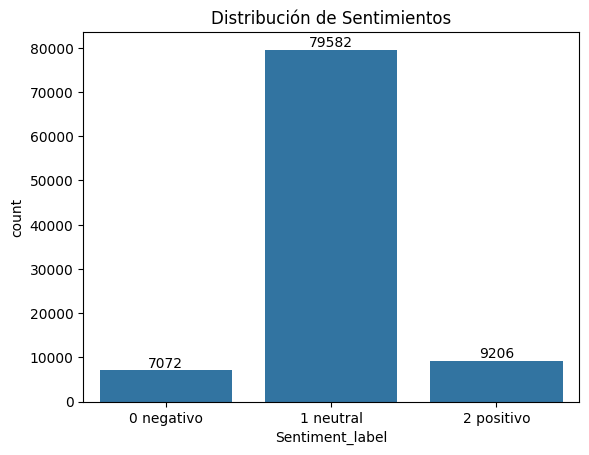

(95860, 5)


PhraseId  SentenceId                                             Phrase  \
1         2           1  A series of escapades demonstrating the adage ...   
2         3           1                                           A series   
3         4           1                                                  A   
4         5           1                                             series   
5         6           1  of escapades demonstrating the adage that what...   

   Sentiment Sentiment_label  
1          1       1 neutral  
2          1       1 neutral  
3          1       1 neutral  
4          1       1 neutral  
5          1       1 neutral

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!export CUDA_LAUNCH_BLOCKING=1


# Cargar el archivo .tsv
df = pd.read_csv('train.tsv', sep='\t')

# Filtrar las categorías 0, 2, y 4
df = df[df['Sentiment'].isin([0, 2, 4])]

# Recategorizar a 0, 1, 2
df['Sentiment'] = df['Sentiment'].map({0: 0, 2: 1, 4: 2})

sentiment_labels = {
    0: '0 negativo',
    1: '1 neutral',
    2: '2 positivo'
}

# Añadir una columna con las etiquetas descriptivas
df['Sentiment_label'] = df['Sentiment'].map(sentiment_labels)

# Crear el gráfico de barras
ax = sns.countplot(x='Sentiment_label', data=df, order=['0 negativo', '1 neutral', '2 positivo'])

# Añadir etiquetas de los valores sobre cada barra usando `ax.bar_label`
ax.bar_label(ax.containers[0], label_type='edge')

plt.title('Distribución de Sentimientos')
plt.show()

# Mostrar la forma y primeras filas del DataFrame
print(df.shape)
df.head()

## Lab 2 Results: Naive Bayes models with variations.

### Preprocesamiento y modelado

In [3]:
DPI=15
ANCHO=20
ALTO=16
WORD= 70

#Random Seed y partición de test establecida
SEED = 13
PARTITION = 0.2

# Preprocesamiento
df['lower_text'] = df['Phrase'].str.lower()

No_Stopwords = df.copy()

No_Stopwords['Phrase_No_Stopwords'] = No_Stopwords['lower_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))

No_Stopwords = No_Stopwords[~No_Stopwords['Phrase_No_Stopwords'].str.fullmatch(r'\s*')]
No_Stopwords = No_Stopwords.drop_duplicates(subset=['Phrase_No_Stopwords', 'Sentiment'])
No_Stopwords = No_Stopwords.dropna(subset=['Phrase_No_Stopwords'])

df['Phrase_Stemmed'] = df['Phrase'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in x.split()]))
No_Stopwords['Phrase_Stemmed'] = No_Stopwords['Phrase_No_Stopwords'].apply(lambda x: ' '.join([PorterStemmer().stem(word) for word in x.split()]))

df['Phrase_Lemmatized'] = df['Phrase'].apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))
No_Stopwords['Phrase_Lemmatized'] = No_Stopwords['Phrase_No_Stopwords'].apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))



#Función de entrenamiento y evaluación Naive Bayes
def train_and_evaluate_model_nb(tipo_data, X, y, average='weighted'):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=PARTITION, random_state=SEED)

    # Crear el modelo de Naive Bayes
    model = MultinomialNB()

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Predecir las clases en el conjunto de prueba
    y_pred = model.predict(X_test)


    # Mostrar el informe de clasificación
    cr = classification_report(y_test, y_pred, target_names=['0 Negativo', '1 Neutral', '2 Positivo'])
    print(cr)

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Definir las etiquetas de las clases
    class_names = ['0 Negativo', '1 Neutral', '2 Positivo']

    # Crear el mapa de calor de la matriz de confusión
    plt.figure(figsize=(ANCHO, ALTO), dpi=DPI)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, annot_kws={"size": WORD}, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    # Ajustar tamaño de las etiquetas de los ejes
    plt.xlabel('Predicted', fontsize=WORD*0.8)  # Ajustar tamaño de la etiqueta del eje x
    plt.ylabel('True', fontsize=WORD*0.8)       # Ajustar tamaño de la etiqueta del eje y

    # Ajustar tamaño de las etiquetas de las marcas en los ejes
    plt.xticks(fontsize=WORD*0.8)             # Ajustar tamaño de las etiquetas de marcas en el eje x
    plt.yticks(fontsize=WORD*0.8)             # Ajustar tamaño de las etiquetas de marcas en el eje y

    plt.title('Confusion Matrix', fontsize=WORD*0.8)  # Ajustar tamaño del título
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

    metricas = {
        'Data': tipo_data,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Classification Report': cr,
        'Matriz de Confusión': cm,
        'Train Registros': len(y_train),
        'Test Registros': len(y_test)
    }

    return metricas


### Evaluación Naive Bayes


Procesando Frases originales...


Entrenando y evaluando el modelo para Frases originales - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.50      0.57      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.63      0.67      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.69      0.73     19172
weighted avg       0.88      0.89      0.88     19172



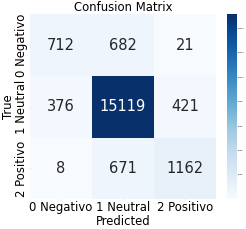

Accuracy: 0.8863446693094096
Precision: 0.8794906684930954
Recall: 0.8863446693094096
F1-Score: 0.8816945428177341

Entrenando y evaluando el modelo para Frases originales - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.52      0.58      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.64      0.68      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.70      0.73     19172
weighted avg       0.88      0.89      0.88     19172



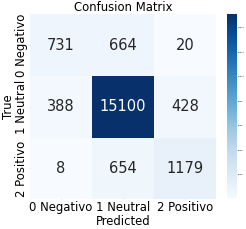

Accuracy: 0.8872313790945129
Precision: 0.8809815200101281
Recall: 0.8872313790945129
F1-Score: 0.8831179887598419

Entrenando y evaluando el modelo para Frases originales - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.82      0.12      0.21      1415
   1 Neutral       0.86      0.99      0.92     15916
  2 Positivo       0.90      0.25      0.40      1841

    accuracy                           0.86     19172
   macro avg       0.86      0.46      0.51     19172
weighted avg       0.86      0.86      0.82     19172



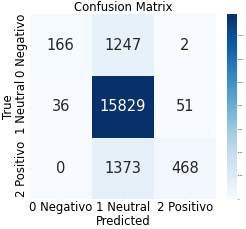

Accuracy: 0.8587001877738368
Precision: 0.8591832243806714
Recall: 0.8587001877738368
F1-Score: 0.8179809867416963

Procesando Frases originales en minúsculas...


Entrenando y evaluando el modelo para Frases originales en minúsculas - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.50      0.57      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.63      0.67      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.69      0.73     19172
weighted avg       0.88      0.89      0.88     19172



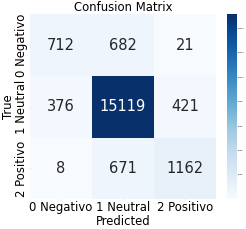

Accuracy: 0.8863446693094096
Precision: 0.8794906684930954
Recall: 0.8863446693094096
F1-Score: 0.8816945428177341

Entrenando y evaluando el modelo para Frases originales en minúsculas - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.52      0.58      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.72      0.64      0.68      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.70      0.73     19172
weighted avg       0.88      0.89      0.88     19172



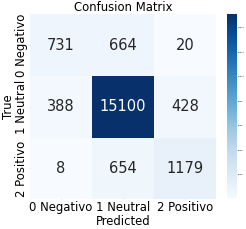

Accuracy: 0.8872313790945129
Precision: 0.8809815200101281
Recall: 0.8872313790945129
F1-Score: 0.8831179887598419

Entrenando y evaluando el modelo para Frases originales en minúsculas - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.82      0.12      0.21      1415
   1 Neutral       0.86      0.99      0.92     15916
  2 Positivo       0.90      0.25      0.40      1841

    accuracy                           0.86     19172
   macro avg       0.86      0.46      0.51     19172
weighted avg       0.86      0.86      0.82     19172



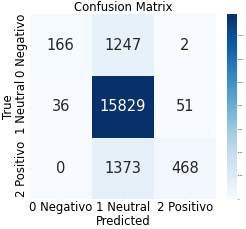

Accuracy: 0.8587001877738368
Precision: 0.8591832243806714
Recall: 0.8587001877738368
F1-Score: 0.8179809867416963

Procesando Frases originales con stemming...


Entrenando y evaluando el modelo para Frases originales con stemming - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.67      0.48      0.56      1415
   1 Neutral       0.91      0.96      0.93     15916
  2 Positivo       0.74      0.59      0.66      1841

    accuracy                           0.89     19172
   macro avg       0.77      0.68      0.72     19172
weighted avg       0.88      0.89      0.88     19172



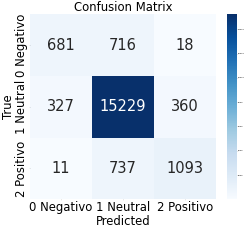

Accuracy: 0.8868662633006468
Precision: 0.8785357821139305
Recall: 0.8868662633006468
F1-Score: 0.8803485879116788

Entrenando y evaluando el modelo para Frases originales con stemming - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.66      0.50      0.57      1415
   1 Neutral       0.91      0.96      0.93     15916
  2 Positivo       0.74      0.60      0.66      1841

    accuracy                           0.89     19172
   macro avg       0.77      0.68      0.72     19172
weighted avg       0.88      0.89      0.88     19172



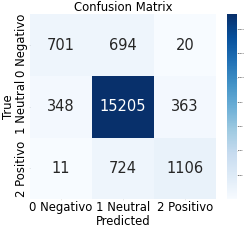

Accuracy: 0.8873356978927602
Precision: 0.879487645321975
Recall: 0.8873356978927602
F1-Score: 0.8814462340617435

Entrenando y evaluando el modelo para Frases originales con stemming - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.81      0.11      0.20      1415
   1 Neutral       0.85      1.00      0.92     15916
  2 Positivo       0.91      0.21      0.34      1841

    accuracy                           0.85     19172
   macro avg       0.86      0.44      0.49     19172
weighted avg       0.86      0.85      0.81     19172



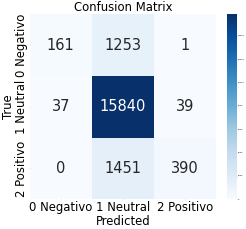

Accuracy: 0.8549447110369288
Precision: 0.8562240640062687
Recall: 0.8549447110369288
F1-Score: 0.8109112273931045

Procesando Frases originales con lemmatization...


Entrenando y evaluando el modelo para Frases originales con lemmatization - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.50      0.56      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.73      0.62      0.67      1841

    accuracy                           0.89     19172
   macro avg       0.77      0.69      0.72     19172
weighted avg       0.88      0.89      0.88     19172



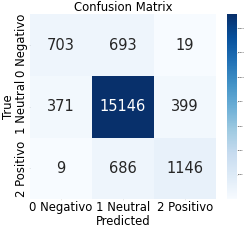

Accuracy: 0.886448988107657
Precision: 0.8791621864188018
Recall: 0.886448988107657
F1-Score: 0.8813547066330496

Entrenando y evaluando el modelo para Frases originales con lemmatization - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.64      0.51      0.57      1415
   1 Neutral       0.92      0.95      0.93     15916
  2 Positivo       0.73      0.63      0.68      1841

    accuracy                           0.89     19172
   macro avg       0.76      0.70      0.73     19172
weighted avg       0.88      0.89      0.88     19172



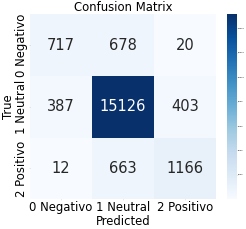

Accuracy: 0.8871792196953892
Precision: 0.8804447515481874
Recall: 0.8871792196953892
F1-Score: 0.8826412361755377

Entrenando y evaluando el modelo para Frases originales con lemmatization - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.81      0.12      0.20      1415
   1 Neutral       0.86      0.99      0.92     15916
  2 Positivo       0.91      0.26      0.40      1841

    accuracy                           0.86     19172
   macro avg       0.86      0.46      0.51     19172
weighted avg       0.86      0.86      0.82     19172



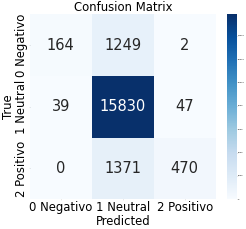

Accuracy: 0.8587523471729606
Precision: 0.8588661246430986
Recall: 0.8587523471729606
F1-Score: 0.8180102222817296

Procesando Frases sin stop words...


Entrenando y evaluando el modelo para Frases sin stop words - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.62      0.51      0.56      1243
   1 Neutral       0.90      0.93      0.91     11240
  2 Positivo       0.71      0.61      0.65      1603

    accuracy                           0.86     14086
   macro avg       0.74      0.68      0.71     14086
weighted avg       0.85      0.86      0.85     14086



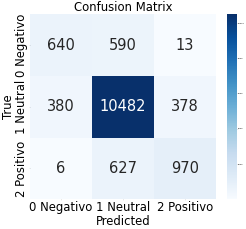

Accuracy: 0.8584410052534431
Precision: 0.8510992951479889
Recall: 0.8584410052534431
F1-Score: 0.8535186768593885

Entrenando y evaluando el modelo para Frases sin stop words - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.62      0.51      0.56      1243
   1 Neutral       0.90      0.93      0.91     11240
  2 Positivo       0.71      0.61      0.66      1603

    accuracy                           0.86     14086
   macro avg       0.74      0.68      0.71     14086
weighted avg       0.85      0.86      0.85     14086



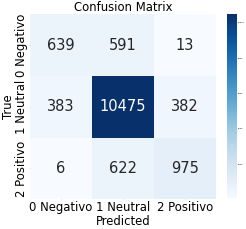

Accuracy: 0.8582280278290502
Precision: 0.8509838382833479
Recall: 0.8582280278290502
F1-Score: 0.8534170513264507

Entrenando y evaluando el modelo para Frases sin stop words - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.78      0.12      0.21      1243
   1 Neutral       0.83      0.99      0.90     11240
  2 Positivo       0.90      0.23      0.37      1603

    accuracy                           0.83     14086
   macro avg       0.84      0.45      0.49     14086
weighted avg       0.83      0.83      0.78     14086



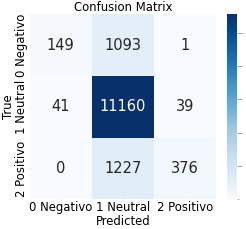

Accuracy: 0.8295470680107908
Precision: 0.8326819790330641
Recall: 0.8295470680107908
F1-Score: 0.7812212351322702

Procesando Frases sin stop words con stemming...


Entrenando y evaluando el modelo para Frases sin stop words con stemming - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.47      0.54      1243
   1 Neutral       0.89      0.94      0.91     11240
  2 Positivo       0.73      0.55      0.63      1603

    accuracy                           0.86     14086
   macro avg       0.76      0.65      0.70     14086
weighted avg       0.85      0.86      0.85     14086



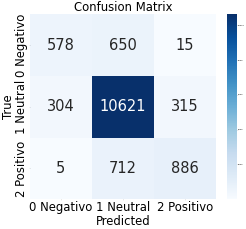

Accuracy: 0.8579440579298594
Precision: 0.8476790734282963
Recall: 0.8579440579298594
F1-Score: 0.8493133173362999

Entrenando y evaluando el modelo para Frases sin stop words con stemming - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.65      0.48      0.55      1243
   1 Neutral       0.89      0.94      0.91     11240
  2 Positivo       0.73      0.55      0.63      1603

    accuracy                           0.86     14086
   macro avg       0.76      0.66      0.70     14086
weighted avg       0.85      0.86      0.85     14086



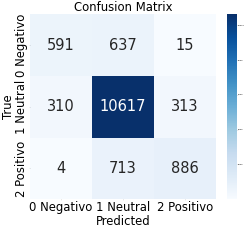

Accuracy: 0.8585829902030385
Precision: 0.8486184589974337
Recall: 0.8585829902030385
F1-Score: 0.8502590471528961

Entrenando y evaluando el modelo para Frases sin stop words con stemming - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.81      0.12      0.20      1243
   1 Neutral       0.82      0.99      0.90     11240
  2 Positivo       0.87      0.19      0.31      1603

    accuracy                           0.82     14086
   macro avg       0.84      0.43      0.47     14086
weighted avg       0.83      0.82      0.77     14086



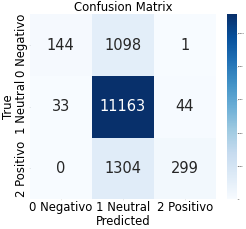

Accuracy: 0.8239386625017748
Precision: 0.8273644050716246
Recall: 0.8239386625017748
F1-Score: 0.7710581591141157

Procesando Frases sin stop words con lemmatization...


Entrenando y evaluando el modelo para Frases sin stop words con lemmatization - BoW Binario...

              precision    recall  f1-score   support

  0 Negativo       0.64      0.50      0.56      1243
   1 Neutral       0.89      0.94      0.92     11240
  2 Positivo       0.72      0.60      0.65      1603

    accuracy                           0.86     14086
   macro avg       0.75      0.68      0.71     14086
weighted avg       0.85      0.86      0.85     14086



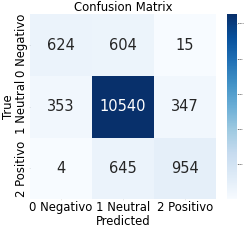

Accuracy: 0.8602868095981826
Precision: 0.8520426026621121
Recall: 0.8602868095981826
F1-Score: 0.8543263489852222

Entrenando y evaluando el modelo para Frases sin stop words con lemmatization - BoW Frecuencia...

              precision    recall  f1-score   support

  0 Negativo       0.63      0.50      0.56      1243
   1 Neutral       0.89      0.94      0.91     11240
  2 Positivo       0.72      0.59      0.65      1603

    accuracy                           0.86     14086
   macro avg       0.75      0.68      0.71     14086
weighted avg       0.85      0.86      0.85     14086



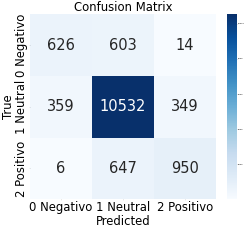

Accuracy: 0.8595768848502059
Precision: 0.851378138664454
Recall: 0.8595768848502059
F1-Score: 0.8536945324899279

Entrenando y evaluando el modelo para Frases sin stop words con lemmatization - BoW TF_IDF...

              precision    recall  f1-score   support

  0 Negativo       0.81      0.12      0.21      1243
   1 Neutral       0.83      0.99      0.90     11240
  2 Positivo       0.89      0.23      0.36      1603

    accuracy                           0.83     14086
   macro avg       0.84      0.45      0.49     14086
weighted avg       0.83      0.83      0.78     14086



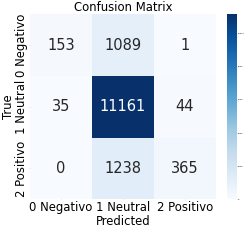

Accuracy: 0.8291211131620049
Precision: 0.8334150741498655
Recall: 0.8291211131620049
F1-Score: 0.7804542681827149


In [4]:
# Definir las columnas y sus respectivos tipo_data
columns_to_process = {
    'Frases originales': ('df', 'Phrase'),
    'Frases originales en minúsculas': ('df', 'lower_text'),
    'Frases originales con stemming': ('df', 'Phrase_Stemmed'),
    'Frases originales con lemmatization': ('df', 'Phrase_Lemmatized'),
    'Frases sin stop words': ('No_Stopwords', 'Phrase_No_Stopwords'),
    'Frases sin stop words con stemming': ('No_Stopwords', 'Phrase_Stemmed'),
    'Frases sin stop words con lemmatization': ('No_Stopwords', 'Phrase_Lemmatized')
}

# Diccionarios para almacenar los resultados
binary_vectors = {}
frequency_vectors = {}
TF_IDF_vectors = {}
resultados = []

# Iterar sobre las columnas y aplicar CountVectorizer
for tipo_data, (dataframe, column) in columns_to_process.items():
    print(f"\nProcesando {tipo_data}...\n")

    # Crear el vectorizador binario (Bag of Words binario)
    vectorizer_binary = CountVectorizer(binary=True)
    if dataframe == 'df':
        X_binary = vectorizer_binary.fit_transform(df[column])
        y = df['Sentiment']
    else:
        X_binary = vectorizer_binary.fit_transform(No_Stopwords[column])
        y = No_Stopwords['Sentiment']

    # Guardar los resultados en el diccionario utilizando tipo_data como clave
    binary_vectors[tipo_data] = (X_binary, y)

    # Entrenar y evaluar el modelo
    print(f"\nEntrenando y evaluando el modelo para {tipo_data} - BoW Binario...\n")
    metricas = train_and_evaluate_model_nb('Naive Bayes - '+tipo_data + ' - BoW Binario', X_binary, y)
    resultados.append(metricas)

    # Crear el vectorizador basado en frecuencia (Bag of Words de frecuencias)
    vectorizer_frequency = CountVectorizer(binary=False)
    if dataframe == 'df':
        X_frequency = vectorizer_frequency.fit_transform(df[column])
        y = df['Sentiment']
    else:
        X_frequency = vectorizer_frequency.fit_transform(No_Stopwords[column])
        y = No_Stopwords['Sentiment']

    # Guardar los resultados en el diccionario utilizando tipo_data como clave
    frequency_vectors[tipo_data] = (X_frequency, y)

    # Entrenar y evaluar el modelo
    print(f"\nEntrenando y evaluando el modelo para {tipo_data} - BoW Frecuencia...\n")
    metricas = train_and_evaluate_model_nb('Naive Bayes - '+ tipo_data + ' - BoW Frecuencia', X_frequency, y)
    resultados.append(metricas)

    # Crear el vectorizador basado en TF_IDF
    vectorizer_TF_IDF = TfidfVectorizer()
    if dataframe == 'df':
        X_TF_IDF = vectorizer_TF_IDF.fit_transform(df[column])
        y = df['Sentiment']
    else:
        X_TF_IDF = vectorizer_TF_IDF.fit_transform(No_Stopwords[column])
        y = No_Stopwords['Sentiment']

    # Guardar los resultados en el diccionario utilizando tipo_data como clave
    TF_IDF_vectors[tipo_data] = (X_TF_IDF, y)

    # Entrenar y evaluar el modelo
    print(f"\nEntrenando y evaluando el modelo para {tipo_data} - BoW TF_IDF...\n")
    metricas = train_and_evaluate_model_nb('Naive Bayes - '+ tipo_data + ' - Bow TF_IDF', X_TF_IDF, y)
    resultados.append(metricas)

## RNN, GRU y LSTM

In [5]:
%pip install torch torchvision torchaudio
%pip install lightning

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Dataset

In [6]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import torchtext
import re

torchtext.disable_torchtext_deprecation_warning()

class TextDataset(Dataset):
    def __init__(self, dataframe, column):
        self.dataframe = dataframe
        self.column = column

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        texto = self.dataframe.iloc[idx][self.column]
        label = self.dataframe.iloc[idx]['Sentiment']
        return texto, label

/home/froh/.local/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/froh/.local/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
[nltk_data] Downloading package punkt to /home/froh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### DataModule

In [7]:
class TextDataModule(pl.LightningDataModule):
    def __init__(self, dataframe, column, batch_size=32, embedding_dim=256):
        super().__init__()
        self.dataframe = dataframe
        self.column = column
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.num_workers = NUM_WORKERS

        self.text_tokenizer = word_tokenize
        self.vocab = self.build_vocab(self.dataframe[self.column])
        self.vocab_size = len(self.vocab)

    def build_vocab(self, texts):
        token_generator = (self.text_tokenizer(text) for text in texts)
        vocab = build_vocab_from_iterator(token_generator, specials=["<unk>"])
        vocab.set_default_index(vocab["<unk>"])
        return vocab

    def setup(self, stage=None):
        train_df, test_df = train_test_split(self.dataframe, test_size=PARTITION, stratify=self.dataframe['Sentiment'], random_state=SEED)
        train_df, val_df = train_test_split(train_df, test_size=PARTITION, stratify=train_df['Sentiment'], random_state=SEED)
        self.train_dataset = TextDataset(train_df, self.column)
        self.val_dataset = TextDataset(val_df, self.column)
        self.test_dataset = TextDataset(test_df, self.column)

    def clean_text(self, text):
        if not isinstance(text, str):
            return ""
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    def tokenize_and_embed_batch(self, batch):
        texts, labels = zip(*batch)
        texts = [self.clean_text(text) for text in texts]

        tokenized_texts = [self.text_tokenizer(text) for text in texts]
        sequences = [torch.tensor(self.vocab(tokens), dtype=torch.long) for tokens in tokenized_texts]
        inputs = pad_sequence(sequences, batch_first=True, padding_value=0)

        labels = torch.tensor([int(label) for label in labels], dtype=torch.long)
        return inputs, labels

    def collate_fn(self, batch):
        return self.tokenize_and_embed_batch(batch)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=self.collate_fn,
            num_workers=self.num_workers
        )

### Modelo

In [8]:
import torchmetrics
import torch.nn as nn
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

class TextClassifierRNN(pl.LightningModule):
    def __init__(self, model_type, n_classes, hidden_dim, n_layers, bidirectional, dropout, embedding_dim, vocab_size):
        super().__init__()
        self.save_hyperparameters()
        self.model_type = model_type
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional
        self.dropout = dropout
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size

        self.test_probs = []
        self.test_preds = []
        self.test_labels = []
        self.test_cm = None
        self.test_classification_report = None  # Para almacenar el reporte de clasificación

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if model_type == "rnn_lstm":
            self.model = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        elif model_type == "rnn_gru":
            self.model = nn.GRU(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        else:
            self.model = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)

        self.classifier = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, n_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average='weighted')
        self.valid_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average='weighted')
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=n_classes, average='weighted')
        self.train_precision = torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='weighted')
        self.valid_precision = torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='weighted')
        self.test_precision = torchmetrics.Precision(task='multiclass', num_classes=n_classes, average='weighted')
        self.train_recall = torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='weighted')
        self.valid_recall = torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='weighted')
        self.test_recall = torchmetrics.Recall(task='multiclass', num_classes=n_classes, average='weighted')
        self.train_f1 = torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='weighted')
        self.valid_f1 = torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='weighted')
        self.test_f1 = torchmetrics.F1Score(task='multiclass', num_classes=n_classes, average='weighted')

    def forward(self, inputs, labels=None):
        embedded = self.embedding(inputs)
        rnn_out, _ = self.model(embedded)
        if self.hparams.bidirectional:
            hidden = torch.cat((rnn_out[:, -1, :self.hparams.hidden_dim], rnn_out[:, 0, self.hparams.hidden_dim:]), dim=1)
        else:
            hidden = rnn_out[:, -1, :]
        logits = self.classifier(hidden)

        loss = 0
        if labels is not None:
            loss = self.criterion(logits, labels)
        return loss, logits

    def training_step(self, batch, batch_idx):
        inputs, labels = batch

        loss, outputs = self(inputs, labels)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        self.train_acc(preds, labels)
        self.train_precision(preds, labels)
        self.train_recall(preds, labels)
        self.train_f1(preds, labels)

        self.log("train_loss", loss, on_epoch=True, on_step=False, logger=True)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.log("train_precision", self.train_precision, on_epoch=True, on_step=False)
        self.log("train_recall", self.train_recall, on_epoch=True, on_step=False)
        self.log("train_f1", self.train_f1, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch

        loss, outputs = self(inputs, labels)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        self.valid_acc(preds, labels)
        self.valid_precision(preds, labels)
        self.valid_recall(preds, labels)
        self.valid_f1(preds, labels)

        self.log("valid_loss", loss, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        self.log("valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True)
        self.log("valid_precision", self.valid_precision, on_epoch=True, on_step=False, prog_bar=True)
        self.log("valid_recall", self.valid_recall, on_epoch=True, on_step=False, prog_bar=True)
        self.log("valid_f1", self.valid_f1, on_epoch=True, on_step=False, prog_bar=True)
        return {"loss": loss, "valid_f1": self.valid_f1}


    def test_step(self, batch, batch_idx):
        inputs, labels = batch

        loss, outputs = self(inputs, labels)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        self.test_probs.extend(probs.cpu().numpy())
        self.test_preds.extend(preds.cpu().numpy())
        self.test_labels.extend(labels.cpu().numpy())

        self.test_acc(preds, labels)
        self.test_precision(preds, labels)
        self.test_recall(preds, labels)
        self.test_f1(preds, labels)

        self.log("test_loss", loss, on_epoch=True, on_step=False, prog_bar=True, logger=True)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False, prog_bar=True)
        self.log("test_precision", self.test_precision, on_epoch=True, on_step=False, prog_bar=True)
        self.log("test_recall", self.test_recall, on_epoch=True, on_step=False, prog_bar=True)
        self.log("test_f1", self.test_f1, on_epoch=True, on_step=False, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-3)
        return optimizer

    def visualize_confusion_matrix(self, labels, predictions, all_categories, title):
        cm = confusion_matrix(labels, predictions)
        plt.figure(figsize=(ANCHO, ALTO), dpi=DPI)  # Ajustar tamaño de la matriz de confusión
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_categories, annot_kws={"size": WORD}, yticklabels=all_categories, cbar=False)
        plt.title(title, fontsize=WORD*0.8)
        plt.xlabel("Predicción")
        plt.ylabel("Etiqueta Verdadera")

        # Ajustar tamaño de las etiquetas de los ejes
        plt.xlabel('Predicted', fontsize=WORD*0.8)  # Ajustar tamaño de la etiqueta del eje x
        plt.ylabel('True', fontsize=WORD*0.8)       # Ajustar tamaño de la etiqueta del eje y

        # Ajustar tamaño de las etiquetas de las marcas en los ejes
        plt.xticks(fontsize=WORD*0.8)             # Ajustar tamaño de las etiquetas de marcas en el eje x
        plt.yticks(fontsize=WORD*0.8)             # Ajustar tamaño de las etiquetas de marcas en el eje y

        plt.show()
        return cm

    def on_test_end(self):
        self.test_cm = self.visualize_confusion_matrix(self.test_labels, self.test_preds, list(range(self.n_classes)), "Matriz Confusión  - Test")
        self.test_classification_report = classification_report(self.test_labels, self.test_preds, target_names=[str(i) for i in range(self.n_classes)])
        print("Classification Report:\n", self.test_classification_report)


## Evaluación RNN, GRU y LSTM normales y bidireccionales


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases originales, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales en minutos: 0.98


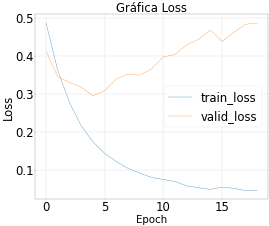

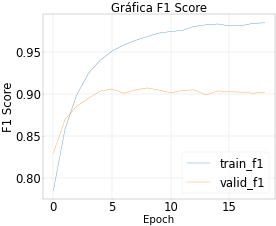

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases originales/rnn_Frases originales/version_4/checkpoints/epoch=18-step=2280.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases originales/rnn_Frases originales/version_4/checkpoints/epoch=18-step=2280.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

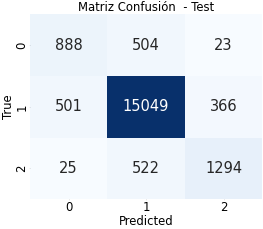

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.63      0.63      1415
           1       0.94      0.95      0.94     15916
           2       0.77      0.70      0.73      1841

    accuracy                           0.90     19172
   macro avg       0.78      0.76      0.77     19172
weighted avg       0.90      0.90      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8987586498260498     │
│          test_f1          │     0.897899866104126     │
│         test_loss         │    0.5103006362915039     │
│      test_precision       │    0.8973636627197266     │
│        test_recall        │    0.8987586498260498     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases originales en minúsculas, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales en minúsculas en minutos: 1.02


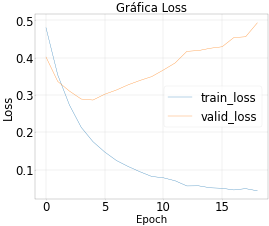

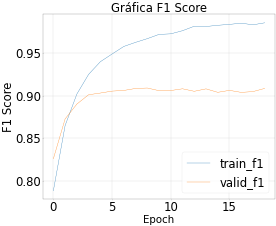

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases originales en minúsculas/rnn_Frases originales en minúsculas/version_3/checkpoints/epoch=18-step=2280.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases originales en minúsculas/rnn_Frases originales en minúsculas/version_3/checkpoints/epoch=18-step=2280.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

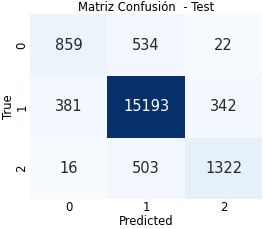

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.61      0.64      1415
           1       0.94      0.95      0.95     15916
           2       0.78      0.72      0.75      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.76      0.78     19172
weighted avg       0.90      0.91      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9062173962593079     │
│          test_f1          │    0.9041742086410522     │
│         test_loss         │    0.5122606754302979     │
│      test_precision       │    0.9028970003128052     │
│        test_recall        │    0.9062173962593079     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases originales con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales con stemming en minutos: 1.00


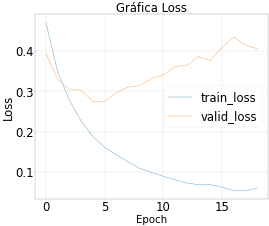

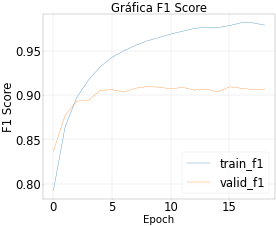

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases originales con stemming/rnn_Frases originales con stemming/version_3/checkpoints/epoch=18-step=2280.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases originales con stemming/rnn_Frases originales con stemming/version_3/checkpoints/epoch=18-step=2280.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

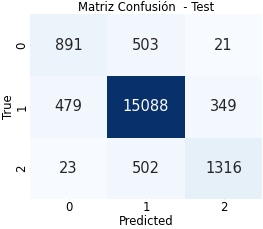

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.63      0.63      1415
           1       0.94      0.95      0.94     15916
           2       0.78      0.71      0.75      1841

    accuracy                           0.90     19172
   macro avg       0.79      0.76      0.77     19172
weighted avg       0.90      0.90      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9020967483520508     │
│          test_f1          │    0.9011256694793701     │
│         test_loss         │    0.4252103269100189     │
│      test_precision       │     0.900485634803772     │
│        test_recall        │    0.9020967483520508     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases originales con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales con lemmatization en minutos: 1.11


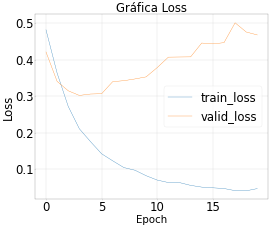

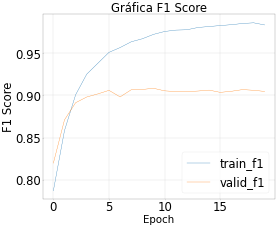

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases originales con lemmatization/rnn_Frases originales con lemmatization/version_3/checkpoints/epoch=19-step=2400.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases originales con lemmatization/rnn_Frases originales con lemmatization/version_3/checkpoints/epoch=19-step=2400.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

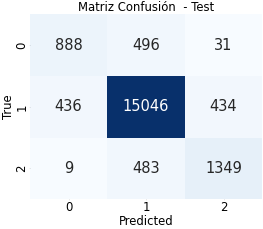

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.63      0.65      1415
           1       0.94      0.95      0.94     15916
           2       0.74      0.73      0.74      1841

    accuracy                           0.90     19172
   macro avg       0.78      0.77      0.78     19172
weighted avg       0.90      0.90      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9014708995819092     │
│          test_f1          │    0.9006946682929993     │
│         test_loss         │    0.4909164309501648     │
│      test_precision       │    0.9000293612480164     │
│        test_recall        │    0.9014708995819092     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases sin stop words, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words en minutos: 0.82


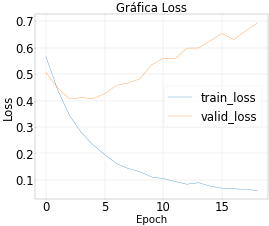

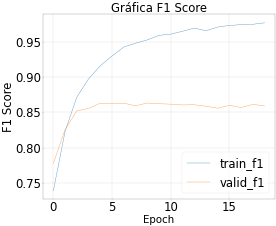

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words/rnn_Frases sin stop words/version_3/checkpoints/epoch=18-step=1691.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words/rnn_Frases sin stop words/version_3/checkpoints/epoch=18-step=1691.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

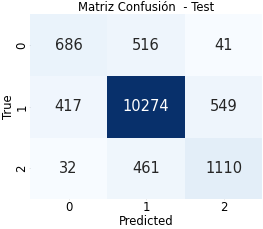

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.55      0.58      1243
           1       0.91      0.91      0.91     11240
           2       0.65      0.69      0.67      1603

    accuracy                           0.86     14086
   macro avg       0.72      0.72      0.72     14086
weighted avg       0.86      0.86      0.86     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8568791747093201     │
│          test_f1          │    0.8564200401306152     │
│         test_loss         │     0.698913037776947     │
│      test_precision       │    0.8563038110733032     │
│        test_recall        │    0.8568791747093201     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases sin stop words con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words con stemming en minutos: 0.84


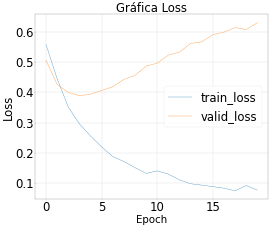

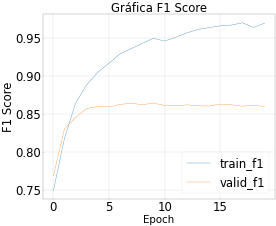

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words con stemming/rnn_Frases sin stop words con stemming/version_3/checkpoints/epoch=19-step=1780.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words con stemming/rnn_Frases sin stop words con stemming/version_3/checkpoints/epoch=19-step=1780.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

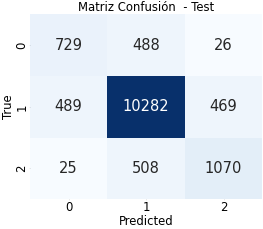

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.59      0.59      1243
           1       0.91      0.91      0.91     11240
           2       0.68      0.67      0.68      1603

    accuracy                           0.86     14086
   macro avg       0.73      0.72      0.73     14086
weighted avg       0.86      0.86      0.86     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8576601147651672     │
│          test_f1          │    0.8573395013809204     │
│         test_loss         │    0.6361865401268005     │
│      test_precision       │     0.85704505443573      │
│        test_recall        │    0.8576601147651672     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases sin stop words con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words con lemmatization en minutos: 1.10


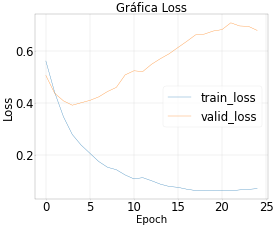

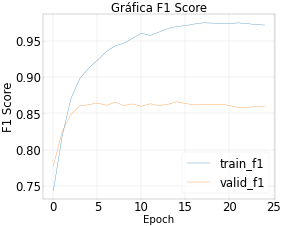

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words con lemmatization/rnn_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=24-step=2225.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words con lemmatization/rnn_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=24-step=2225.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

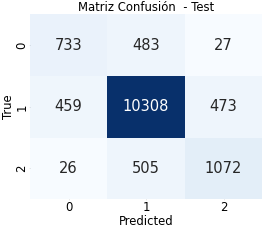

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.59      0.60      1243
           1       0.91      0.92      0.91     11240
           2       0.68      0.67      0.68      1603

    accuracy                           0.86     14086
   macro avg       0.73      0.73      0.73     14086
weighted avg       0.86      0.86      0.86     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8599318265914917     │
│          test_f1          │    0.8593851327896118     │
│         test_loss         │    0.6871614456176758     │
│      test_precision       │    0.8588728904724121     │
│        test_recall        │    0.8599318265914917     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases originales, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales en minutos: 1.07


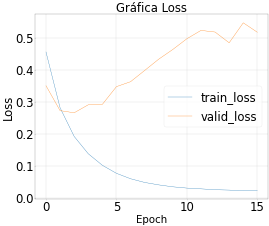

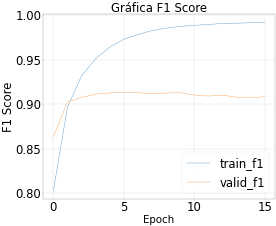

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales/rnn_lstm_Frases originales/version_2/checkpoints/epoch=15-step=1920.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales/rnn_lstm_Frases originales/version_2/checkpoints/epoch=15-step=1920.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

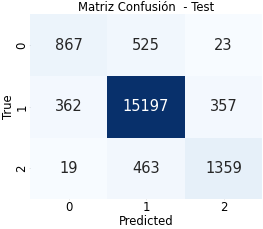

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.61      0.65      1415
           1       0.94      0.95      0.95     15916
           2       0.78      0.74      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.77      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9087731838226318     │
│          test_f1          │      0.9069864153862      │
│         test_loss         │    0.5340033173561096     │
│      test_precision       │    0.9058079123497009     │
│        test_recall        │    0.9087731838226318     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases originales en minúsculas, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales en minúsculas en minutos: 1.15


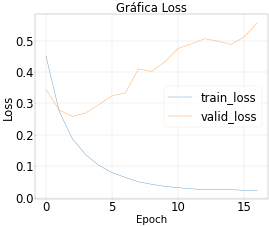

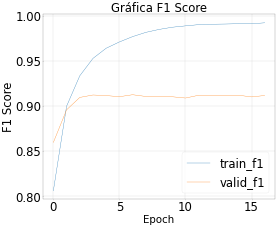

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales en minúsculas/rnn_lstm_Frases originales en minúsculas/version_2/checkpoints/epoch=16-step=2040.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales en minúsculas/rnn_lstm_Frases originales en minúsculas/version_2/checkpoints/epoch=16-step=2040.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

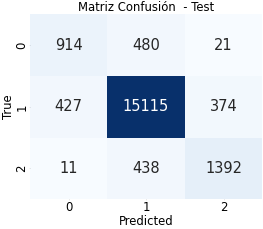

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.66      1415
           1       0.94      0.95      0.95     15916
           2       0.78      0.76      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.78      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9086688756942749     │
│          test_f1          │     0.907947838306427     │
│         test_loss         │    0.5718755722045898     │
│      test_precision       │     0.907331109046936     │
│        test_recall        │    0.9086688756942749     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases originales con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales con stemming en minutos: 1.06


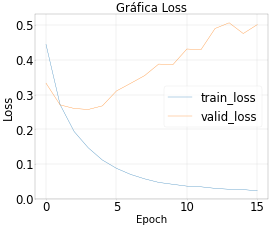

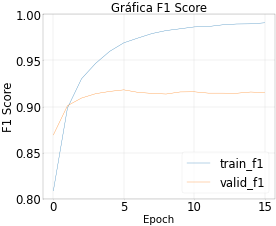

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales con stemming/rnn_lstm_Frases originales con stemming/version_2/checkpoints/epoch=15-step=1920.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales con stemming/rnn_lstm_Frases originales con stemming/version_2/checkpoints/epoch=15-step=1920.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

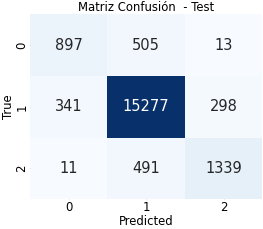

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1415
           1       0.94      0.96      0.95     15916
           2       0.81      0.73      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.82      0.77      0.80     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.913467526435852     │
│          test_f1          │    0.9113665819168091     │
│         test_loss         │    0.5207996964454651     │
│      test_precision       │    0.9102893471717834     │
│        test_recall        │     0.913467526435852     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases originales con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales con lemmatization en minutos: 1.16


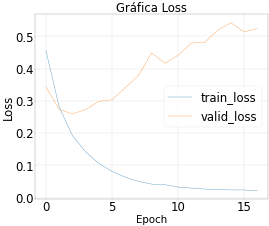

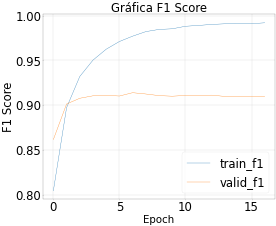

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales con lemmatization/rnn_lstm_Frases originales con lemmatization/version_2/checkpoints/epoch=16-step=2040.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales con lemmatization/rnn_lstm_Frases originales con lemmatization/version_2/checkpoints/epoch=16-step=2040.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

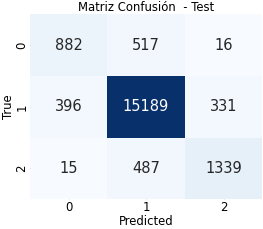

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.62      0.65      1415
           1       0.94      0.95      0.95     15916
           2       0.79      0.73      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.77      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.908095121383667     │
│          test_f1          │    0.9064023494720459     │
│         test_loss         │    0.5582505464553833     │
│      test_precision       │    0.9053042531013489     │
│        test_recall        │     0.908095121383667     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases sin stop words, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words en minutos: 0.81


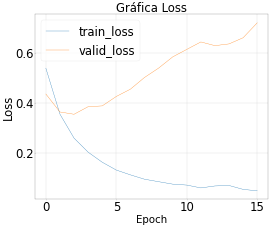

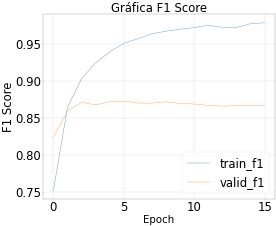

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words/rnn_lstm_Frases sin stop words/version_2/checkpoints/epoch=15-step=1424.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words/rnn_lstm_Frases sin stop words/version_2/checkpoints/epoch=15-step=1424.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

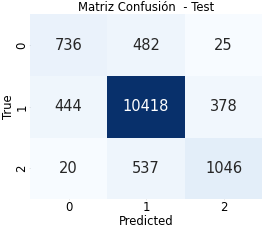

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.59      0.60      1243
           1       0.91      0.93      0.92     11240
           2       0.72      0.65      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.75      0.72      0.74     14086
weighted avg       0.86      0.87      0.86     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8661081790924072     │
│          test_f1          │    0.8643497824668884     │
│         test_loss         │    0.7308921813964844     │
│      test_precision       │    0.8631331920623779     │
│        test_recall        │    0.8661081790924072     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases sin stop words con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words con stemming en minutos: 0.81


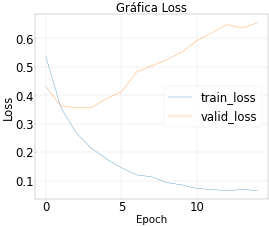

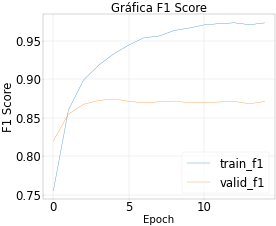

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words con stemming/rnn_lstm_Frases sin stop words con stemming/version_2/checkpoints/epoch=14-step=1335.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words con stemming/rnn_lstm_Frases sin stop words con stemming/version_2/checkpoints/epoch=14-step=1335.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

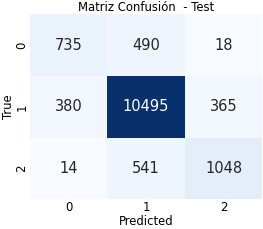

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.59      0.62      1243
           1       0.91      0.93      0.92     11240
           2       0.73      0.65      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.76      0.73      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8716456294059753     │
│          test_f1          │    0.8690111637115479     │
│         test_loss         │    0.6616173386573792     │
│      test_precision       │    0.8673692941665649     │
│        test_recall        │    0.8716456294059753     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases sin stop words con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words con lemmatization en minutos: 0.74


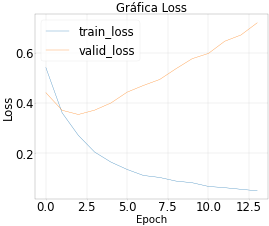

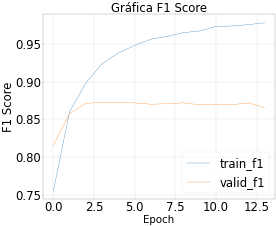

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words con lemmatization/rnn_lstm_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=13-step=1246.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words con lemmatization/rnn_lstm_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=13-step=1246.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

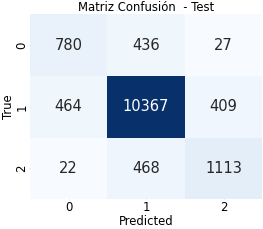

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.63      0.62      1243
           1       0.92      0.92      0.92     11240
           2       0.72      0.69      0.71      1603

    accuracy                           0.87     14086
   macro avg       0.75      0.75      0.75     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.870367705821991     │
│          test_f1          │    0.8702002763748169     │
│         test_loss         │    0.7114267349243164     │
│      test_precision       │    0.8700920343399048     │
│        test_recall        │     0.870367705821991     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases originales, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales en minutos: 1.09


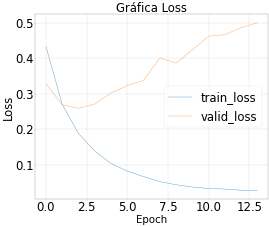

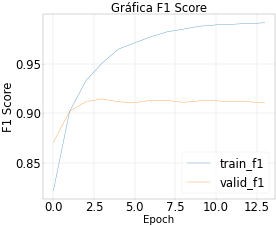

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales/rnn_gru_Frases originales/version_2/checkpoints/epoch=13-step=1680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales/rnn_gru_Frases originales/version_2/checkpoints/epoch=13-step=1680.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

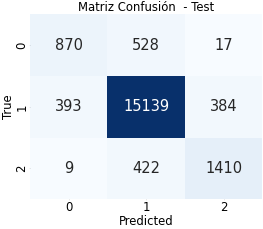

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.61      0.65      1415
           1       0.94      0.95      0.95     15916
           2       0.78      0.77      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.78      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.908564567565918     │
│          test_f1          │    0.9073154330253601     │
│         test_loss         │    0.5239916443824768     │
│      test_precision       │    0.9063935875892639     │
│        test_recall        │     0.908564567565918     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases originales en minúsculas, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales en minúsculas en minutos: 1.36


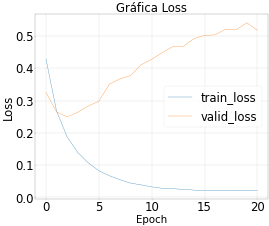

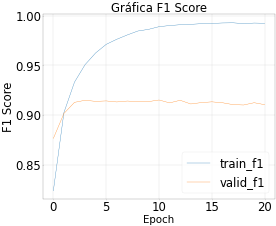

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales en minúsculas/rnn_gru_Frases originales en minúsculas/version_2/checkpoints/epoch=20-step=2520.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales en minúsculas/rnn_gru_Frases originales en minúsculas/version_2/checkpoints/epoch=20-step=2520.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

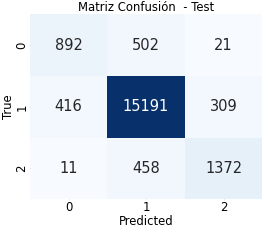

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.63      0.65      1415
           1       0.94      0.95      0.95     15916
           2       0.81      0.75      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.78      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9104423522949219     │
│          test_f1          │    0.9090769290924072     │
│         test_loss         │    0.5326063632965088     │
│      test_precision       │    0.9081441164016724     │
│        test_recall        │    0.9104423522949219     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases originales con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales con stemming en minutos: 1.20


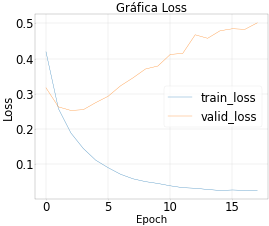

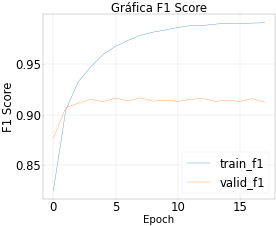

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales con stemming/rnn_gru_Frases originales con stemming/version_2/checkpoints/epoch=17-step=2160.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales con stemming/rnn_gru_Frases originales con stemming/version_2/checkpoints/epoch=17-step=2160.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

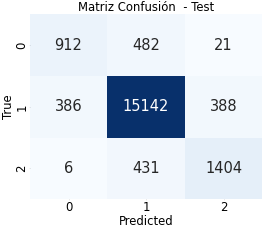

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67      1415
           1       0.94      0.95      0.95     15916
           2       0.77      0.76      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.79      0.80     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9105987548828125     │
│          test_f1          │    0.9096681475639343     │
│         test_loss         │    0.5239619612693787     │
│      test_precision       │    0.9089411497116089     │
│        test_recall        │    0.9105987548828125     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases originales con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales con lemmatization en minutos: 0.98


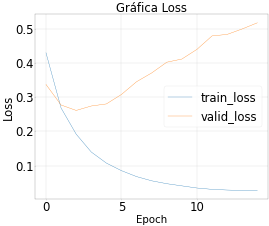

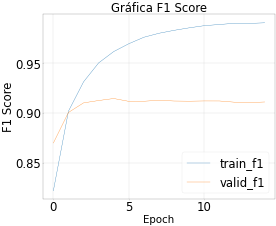

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales con lemmatization/rnn_gru_Frases originales con lemmatization/version_2/checkpoints/epoch=14-step=1800.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales con lemmatization/rnn_gru_Frases originales con lemmatization/version_2/checkpoints/epoch=14-step=1800.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

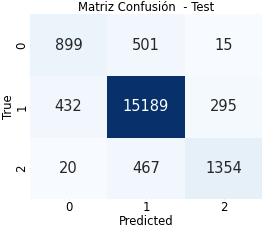

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.64      0.65      1415
           1       0.94      0.95      0.95     15916
           2       0.81      0.74      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.78      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9097642302513123     │
│          test_f1          │     0.908462643623352     │
│         test_loss         │     0.526839554309845     │
│      test_precision       │    0.9076806306838989     │
│        test_recall        │    0.9097642302513123     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases sin stop words, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words en minutos: 0.83


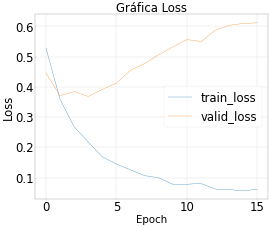

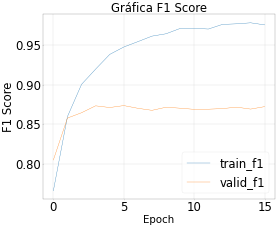

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words/rnn_gru_Frases sin stop words/version_2/checkpoints/epoch=15-step=1424.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words/rnn_gru_Frases sin stop words/version_2/checkpoints/epoch=15-step=1424.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

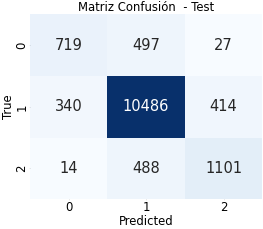

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.58      0.62      1243
           1       0.91      0.93      0.92     11240
           2       0.71      0.69      0.70      1603

    accuracy                           0.87     14086
   macro avg       0.77      0.73      0.75     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8736333847045898     │
│          test_f1          │    0.8713244199752808     │
│         test_loss         │    0.6083335876464844     │
│      test_precision       │    0.8698214292526245     │
│        test_recall        │    0.8736333847045898     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases sin stop words con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words con stemming en minutos: 0.80


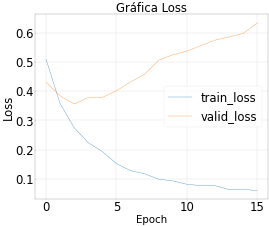

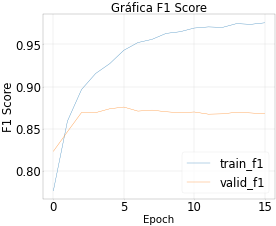

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words con stemming/rnn_gru_Frases sin stop words con stemming/version_2/checkpoints/epoch=15-step=1424.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words con stemming/rnn_gru_Frases sin stop words con stemming/version_2/checkpoints/epoch=15-step=1424.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

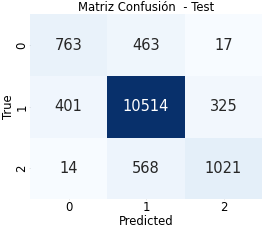

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.61      0.63      1243
           1       0.91      0.94      0.92     11240
           2       0.75      0.64      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.77      0.73      0.75     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8730654716491699     │
│          test_f1          │    0.8703933954238892     │
│         test_loss         │    0.6253123879432678     │
│      test_precision       │    0.8690983057022095     │
│        test_recall        │    0.8730654716491699     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases sin stop words con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words con lemmatization en minutos: 0.78


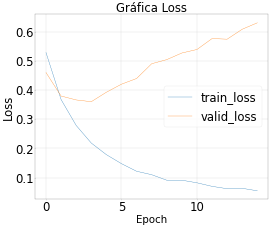

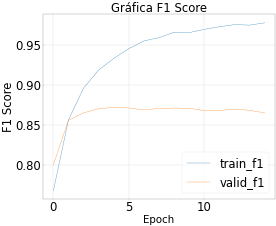

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words con lemmatization/rnn_gru_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=14-step=1335.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words con lemmatization/rnn_gru_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=14-step=1335.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

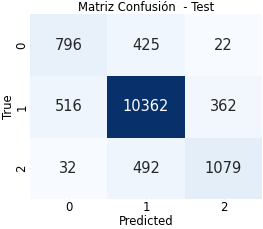

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.64      0.62      1243
           1       0.92      0.92      0.92     11240
           2       0.74      0.67      0.70      1603

    accuracy                           0.87     14086
   macro avg       0.75      0.75      0.75     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8687348961830139     │
│          test_f1          │    0.8687523603439331     │
│         test_loss         │    0.6198096871376038     │
│      test_precision       │     0.869274914264679     │
│        test_recall        │    0.8687348961830139     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases originales, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales en minutos: 1.60


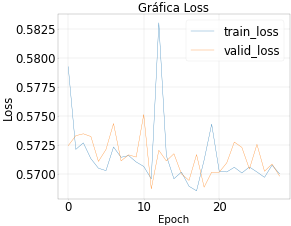

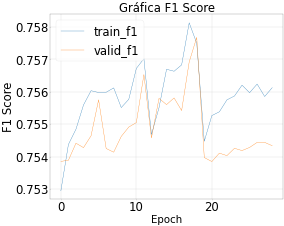

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases originales/rnn_Frases originales/version_2/checkpoints/epoch=28-step=3480.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases originales/rnn_Frases originales/version_2/checkpoints/epoch=28-step=3480.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

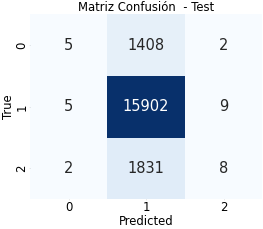

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.00      0.01      1415
           1       0.83      1.00      0.91     15916
           2       0.42      0.00      0.01      1841

    accuracy                           0.83     19172
   macro avg       0.56      0.34      0.31     19172
weighted avg       0.76      0.83      0.75     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8301168084144592     │
│          test_f1          │    0.7544794082641602     │
│         test_loss         │    0.5706324577331543     │
│      test_precision       │    0.7608736753463745     │
│        test_recall        │    0.8301168084144592     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases originales en minúsculas, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales en minúsculas en minutos: 0.88


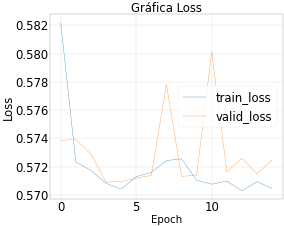

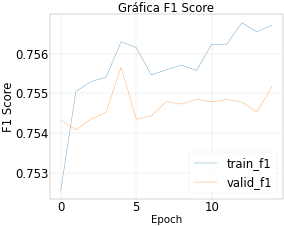

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases originales en minúsculas/rnn_Frases originales en minúsculas/version_2/checkpoints/epoch=14-step=1800.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases originales en minúsculas/rnn_Frases originales en minúsculas/version_2/checkpoints/epoch=14-step=1800.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

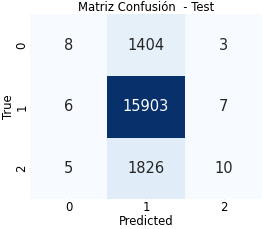

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.01      0.01      1415
           1       0.83      1.00      0.91     15916
           2       0.50      0.01      0.01      1841

    accuracy                           0.83     19172
   macro avg       0.58      0.34      0.31     19172
weighted avg       0.77      0.83      0.76     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8304297924041748     │
│          test_f1          │    0.7552109360694885     │
│         test_loss         │    0.5724810361862183     │
│      test_precision       │    0.7691100239753723     │
│        test_recall        │    0.8304297924041748     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases originales con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales con stemming en minutos: 1.89


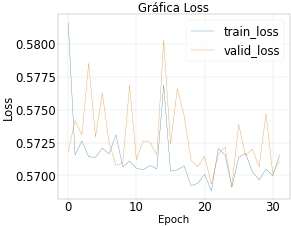

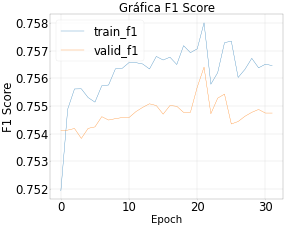

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases originales con stemming/rnn_Frases originales con stemming/version_2/checkpoints/epoch=31-step=3840.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases originales con stemming/rnn_Frases originales con stemming/version_2/checkpoints/epoch=31-step=3840.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

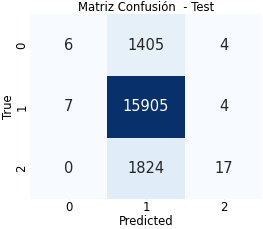

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.00      0.01      1415
           1       0.83      1.00      0.91     15916
           2       0.68      0.01      0.02      1841

    accuracy                           0.83     19172
   macro avg       0.66      0.34      0.31     19172
weighted avg       0.79      0.83      0.76     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8307949304580688     │
│          test_f1          │    0.7557985782623291     │
│         test_loss         │     0.571086585521698     │
│      test_precision       │    0.7894334197044373     │
│        test_recall        │    0.8307949304580688     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases originales con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales con lemmatization en minutos: 0.92


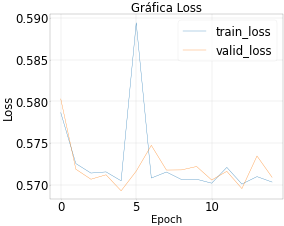

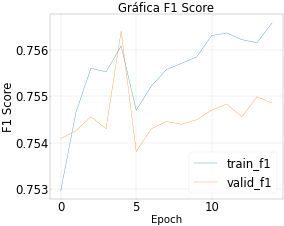

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases originales con lemmatization/rnn_Frases originales con lemmatization/version_2/checkpoints/epoch=14-step=1800.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases originales con lemmatization/rnn_Frases originales con lemmatization/version_2/checkpoints/epoch=14-step=1800.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

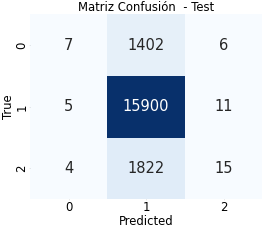

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.00      0.01      1415
           1       0.83      1.00      0.91     15916
           2       0.47      0.01      0.02      1841

    accuracy                           0.83     19172
   macro avg       0.58      0.34      0.31     19172
weighted avg       0.77      0.83      0.76     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8304819464683533     │
│          test_f1          │    0.7556669116020203     │
│         test_loss         │    0.5715281963348389     │
│      test_precision       │    0.7675176858901978     │
│        test_recall        │    0.8304819464683533     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases sin stop words, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words en minutos: 0.59


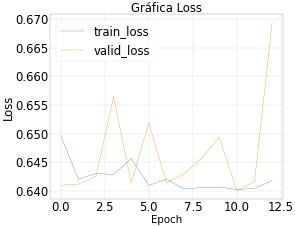

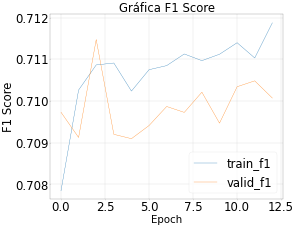

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words/rnn_Frases sin stop words/version_2/checkpoints/epoch=12-step=1157.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words/rnn_Frases sin stop words/version_2/checkpoints/epoch=12-step=1157.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

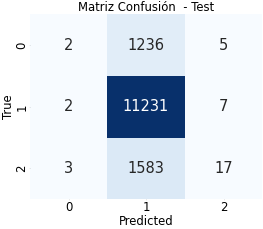

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.00      0.00      1243
           1       0.80      1.00      0.89     11240
           2       0.59      0.01      0.02      1603

    accuracy                           0.80     14086
   macro avg       0.56      0.34      0.30     14086
weighted avg       0.73      0.80      0.71     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7986653447151184     │
│          test_f1          │    0.7113789916038513     │
│         test_loss         │    0.6690406799316406     │
│      test_precision       │    0.7297765016555786     │
│        test_recall        │    0.7986653447151184     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases sin stop words con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words con stemming en minutos: 1.52


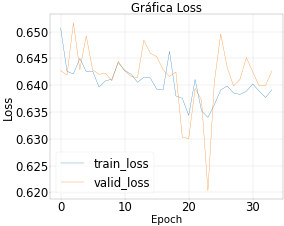

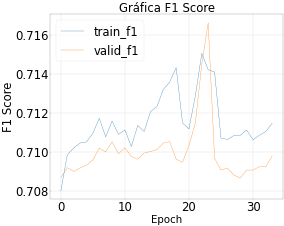

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words con stemming/rnn_Frases sin stop words con stemming/version_2/checkpoints/epoch=33-step=3026.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words con stemming/rnn_Frases sin stop words con stemming/version_2/checkpoints/epoch=33-step=3026.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

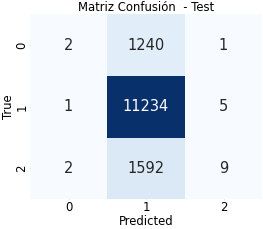

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.00      0.00      1243
           1       0.80      1.00      0.89     11240
           2       0.60      0.01      0.01      1603

    accuracy                           0.80     14086
   macro avg       0.60      0.34      0.30     14086
weighted avg       0.74      0.80      0.71     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.798310399055481     │
│          test_f1          │    0.7100156545639038     │
│         test_loss         │    0.6411706209182739     │
│      test_precision       │    0.7408758401870728     │
│        test_recall        │     0.798310399055481     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases sin stop words con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words con lemmatization en minutos: 0.78


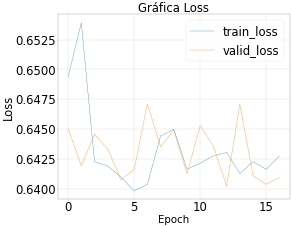

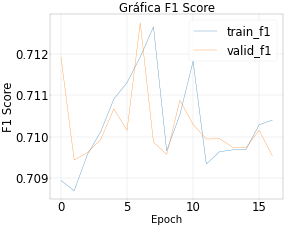

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words con lemmatization/rnn_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=16-step=1513.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words con lemmatization/rnn_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=16-step=1513.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

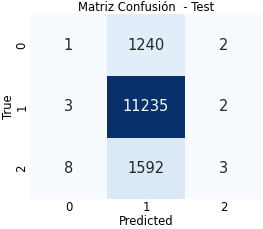

Classification Report:
               precision    recall  f1-score   support

           0       0.08      0.00      0.00      1243
           1       0.80      1.00      0.89     11240
           2       0.43      0.00      0.00      1603

    accuracy                           0.80     14086
   macro avg       0.44      0.33      0.30     14086
weighted avg       0.69      0.80      0.71     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7978844046592712     │
│          test_f1          │    0.7090666890144348     │
│         test_loss         │    0.6406204104423523     │
│      test_precision       │    0.6934346556663513     │
│        test_recall        │    0.7978844046592712     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases originales, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales en minutos: 1.12


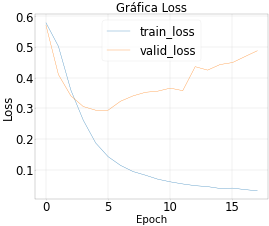

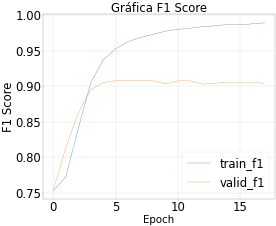

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales/rnn_lstm_Frases originales/version_2/checkpoints/epoch=17-step=2160.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales/rnn_lstm_Frases originales/version_2/checkpoints/epoch=17-step=2160.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

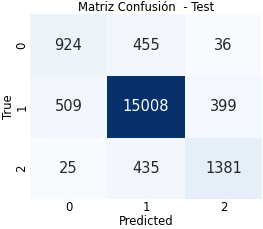

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      1415
           1       0.94      0.94      0.94     15916
           2       0.76      0.75      0.76      1841

    accuracy                           0.90     19172
   macro avg       0.78      0.78      0.78     19172
weighted avg       0.90      0.90      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9030356407165527     │
│          test_f1          │    0.9032496809959412     │
│         test_loss         │    0.5074201822280884     │
│      test_precision       │    0.9034922122955322     │
│        test_recall        │    0.9030356407165527     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases originales en minúsculas, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales en minúsculas en minutos: 1.26


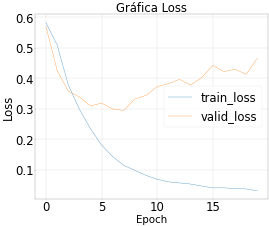

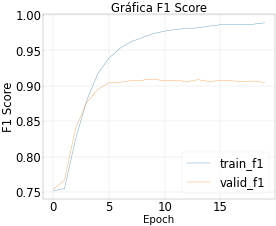

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales en minúsculas/rnn_lstm_Frases originales en minúsculas/version_2/checkpoints/epoch=19-step=2400.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales en minúsculas/rnn_lstm_Frases originales en minúsculas/version_2/checkpoints/epoch=19-step=2400.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

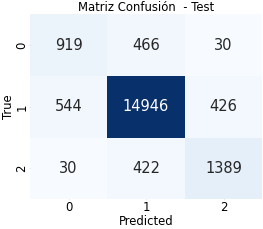

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.65      0.63      1415
           1       0.94      0.94      0.94     15916
           2       0.75      0.75      0.75      1841

    accuracy                           0.90     19172
   macro avg       0.77      0.78      0.78     19172
weighted avg       0.90      0.90      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8999583125114441     │
│          test_f1          │    0.9006073474884033     │
│         test_loss         │    0.4886574149131775     │
│      test_precision       │    0.9013341665267944     │
│        test_recall        │    0.8999583125114441     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases originales con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales con stemming en minutos: 1.10


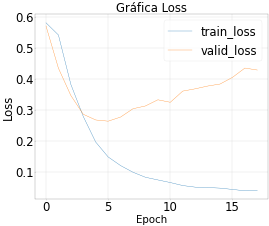

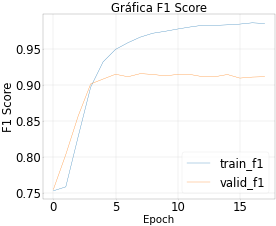

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales con stemming/rnn_lstm_Frases originales con stemming/version_2/checkpoints/epoch=17-step=2160.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales con stemming/rnn_lstm_Frases originales con stemming/version_2/checkpoints/epoch=17-step=2160.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

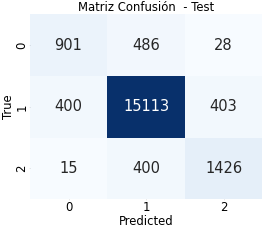

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.64      0.66      1415
           1       0.94      0.95      0.95     15916
           2       0.77      0.77      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.79      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9096599221229553     │
│          test_f1          │    0.9089916348457336     │
│         test_loss         │    0.4333764612674713     │
│      test_precision       │    0.9084650278091431     │
│        test_recall        │    0.9096599221229553     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases originales con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales con lemmatization en minutos: 1.56


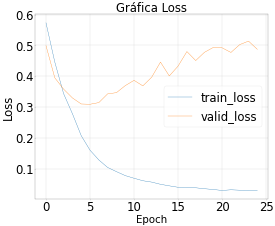

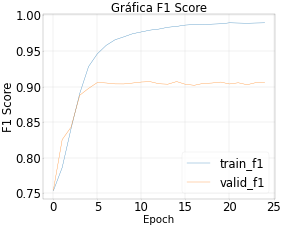

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales con lemmatization/rnn_lstm_Frases originales con lemmatization/version_2/checkpoints/epoch=24-step=3000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales con lemmatization/rnn_lstm_Frases originales con lemmatization/version_2/checkpoints/epoch=24-step=3000.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

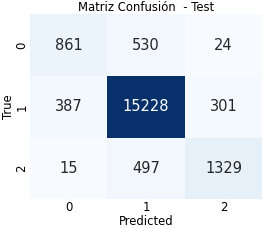

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.61      0.64      1415
           1       0.94      0.96      0.95     15916
           2       0.80      0.72      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.76      0.78     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9085124135017395     │
│          test_f1          │    0.9064006209373474     │
│         test_loss         │    0.4872504472732544     │
│      test_precision       │    0.9051895141601562     │
│        test_recall        │    0.9085124135017395     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases sin stop words, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words en minutos: 0.85


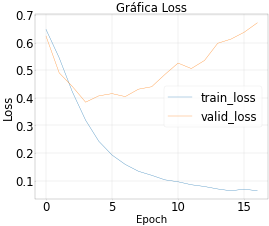

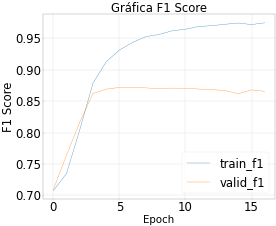

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words/rnn_lstm_Frases sin stop words/version_2/checkpoints/epoch=16-step=1513.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words/rnn_lstm_Frases sin stop words/version_2/checkpoints/epoch=16-step=1513.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

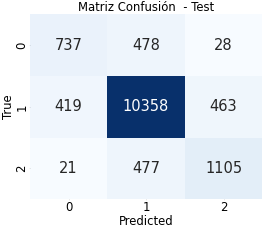

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.59      0.61      1243
           1       0.92      0.92      0.92     11240
           2       0.69      0.69      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.74      0.73      0.74     14086
weighted avg       0.86      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8661081790924072     │
│          test_f1          │    0.8653266429901123     │
│         test_loss         │    0.6704919934272766     │
│      test_precision       │    0.8646411895751953     │
│        test_recall        │    0.8661081790924072     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases sin stop words con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words con stemming en minutos: 1.05


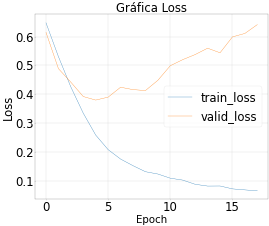

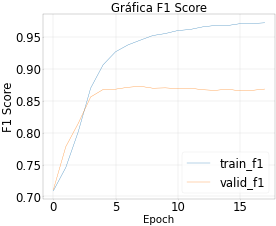

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words con stemming/rnn_lstm_Frases sin stop words con stemming/version_2/checkpoints/epoch=17-step=1602.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words con stemming/rnn_lstm_Frases sin stop words con stemming/version_2/checkpoints/epoch=17-step=1602.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

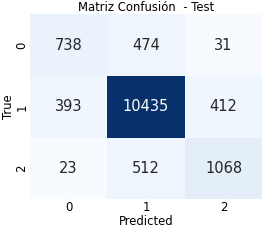

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.59      0.62      1243
           1       0.91      0.93      0.92     11240
           2       0.71      0.67      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.75      0.73      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8690188527107239     │
│          test_f1          │    0.8672871589660645     │
│         test_loss         │    0.6447474956512451     │
│      test_precision       │    0.8659356832504272     │
│        test_recall        │    0.8690188527107239     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases sin stop words con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words con lemmatization en minutos: 0.90


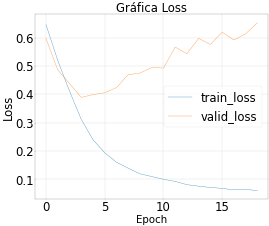

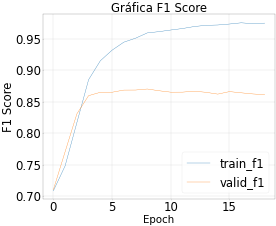

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words con lemmatization/rnn_lstm_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=18-step=1691.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words con lemmatization/rnn_lstm_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=18-step=1691.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

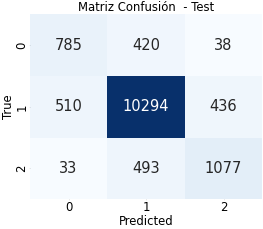

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.63      0.61      1243
           1       0.92      0.92      0.92     11240
           2       0.69      0.67      0.68      1603

    accuracy                           0.86     14086
   macro avg       0.73      0.74      0.74     14086
weighted avg       0.86      0.86      0.86     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8629845380783081     │
│          test_f1          │    0.8634770512580872     │
│         test_loss         │    0.6432401537895203     │
│      test_precision       │     0.864132821559906     │
│        test_recall        │    0.8629845380783081     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases originales, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales en minutos: 0.86


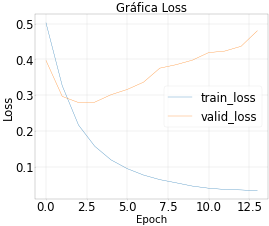

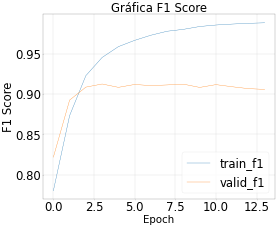

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales/rnn_gru_Frases originales/version_2/checkpoints/epoch=13-step=1680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales/rnn_gru_Frases originales/version_2/checkpoints/epoch=13-step=1680.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

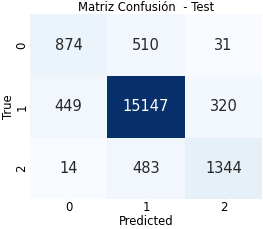

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.62      0.64      1415
           1       0.94      0.95      0.95     15916
           2       0.79      0.73      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.77      0.78     19172
weighted avg       0.90      0.91      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9057480096817017     │
│          test_f1          │    0.9044138193130493     │
│         test_loss         │    0.49486005306243896    │
│      test_precision       │    0.9034809470176697     │
│        test_recall        │    0.9057480096817017     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases originales en minúsculas, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales en minúsculas en minutos: 0.83


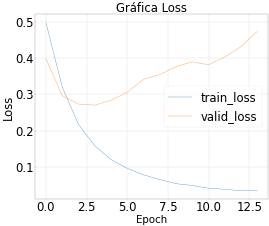

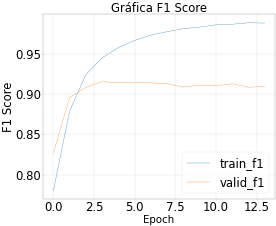

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales en minúsculas/rnn_gru_Frases originales en minúsculas/version_2/checkpoints/epoch=13-step=1680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales en minúsculas/rnn_gru_Frases originales en minúsculas/version_2/checkpoints/epoch=13-step=1680.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

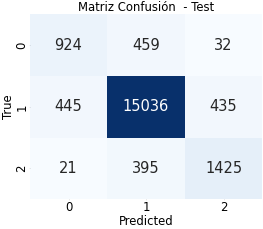

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.65      0.66      1415
           1       0.95      0.94      0.95     15916
           2       0.75      0.77      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.79      0.79      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9067911505699158     │
│          test_f1          │    0.9068464040756226     │
│         test_loss         │     0.47914919257164      │
│      test_precision       │    0.9069377183914185     │
│        test_recall        │    0.9067911505699158     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases originales con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales con stemming en minutos: 1.03


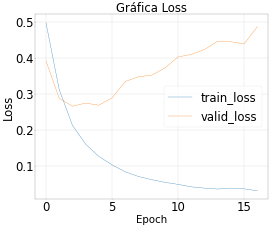

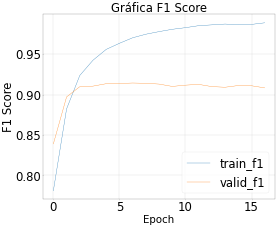

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales con stemming/rnn_gru_Frases originales con stemming/version_2/checkpoints/epoch=16-step=2040.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales con stemming/rnn_gru_Frases originales con stemming/version_2/checkpoints/epoch=16-step=2040.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

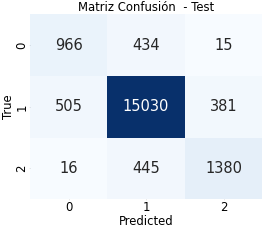

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      1415
           1       0.94      0.94      0.94     15916
           2       0.78      0.75      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.79      0.79      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9063217043876648     │
│          test_f1          │    0.9065375924110413     │
│         test_loss         │    0.4854622483253479     │
│      test_precision       │    0.9068613648414612     │
│        test_recall        │    0.9063217043876648     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases originales con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales con lemmatization en minutos: 0.84


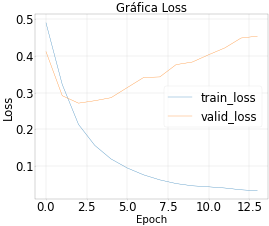

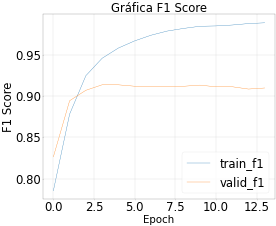

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales con lemmatization/rnn_gru_Frases originales con lemmatization/version_2/checkpoints/epoch=13-step=1680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales con lemmatization/rnn_gru_Frases originales con lemmatization/version_2/checkpoints/epoch=13-step=1680.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

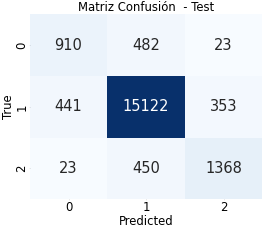

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.64      0.65      1415
           1       0.94      0.95      0.95     15916
           2       0.78      0.74      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.78      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9075735807418823     │
│          test_f1          │    0.9067972898483276     │
│         test_loss         │    0.4731644093990326     │
│      test_precision       │     0.90617835521698      │
│        test_recall        │    0.9075735807418823     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases sin stop words, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words en minutos: 0.78


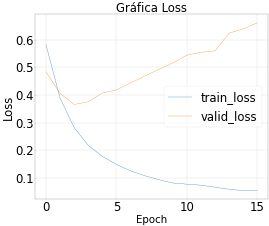

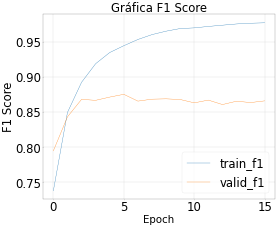

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words/rnn_gru_Frases sin stop words/version_2/checkpoints/epoch=15-step=1424.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words/rnn_gru_Frases sin stop words/version_2/checkpoints/epoch=15-step=1424.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

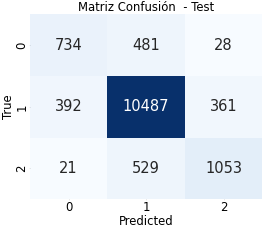

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.59      0.61      1243
           1       0.91      0.93      0.92     11240
           2       0.73      0.66      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.76      0.73      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8713616132736206     │
│          test_f1          │    0.8689920902252197     │
│         test_loss         │    0.6587139964103699     │
│      test_precision       │    0.8674271106719971     │
│        test_recall        │    0.8713616132736206     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases sin stop words con stemming, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words con stemming en minutos: 0.77


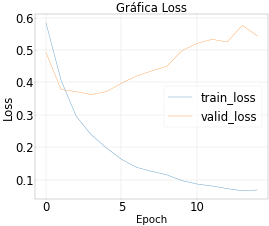

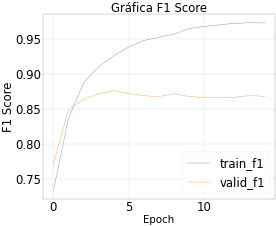

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words con stemming/rnn_gru_Frases sin stop words con stemming/version_2/checkpoints/epoch=14-step=1335.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words con stemming/rnn_gru_Frases sin stop words con stemming/version_2/checkpoints/epoch=14-step=1335.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

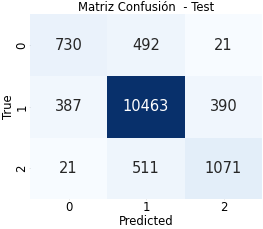

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.59      0.61      1243
           1       0.91      0.93      0.92     11240
           2       0.72      0.67      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.76      0.73      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8706517219543457     │
│          test_f1          │    0.8685259819030762     │
│         test_loss         │    0.5609166622161865     │
│      test_precision       │    0.8670004606246948     │
│        test_recall        │    0.8706517219543457     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases sin stop words con lemmatization, con patience: 10...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words con lemmatization en minutos: 0.80


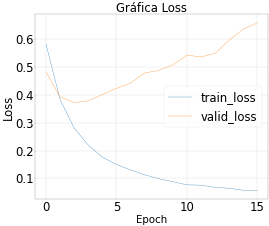

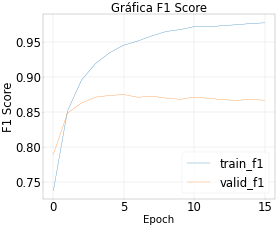

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words con lemmatization/rnn_gru_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=15-step=1424.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words con lemmatization/rnn_gru_Frases sin stop words con lemmatization/version_2/checkpoints/epoch=15-step=1424.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

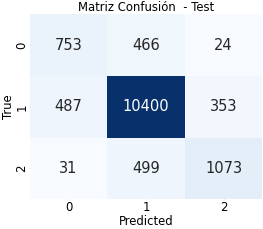

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.61      0.60      1243
           1       0.92      0.93      0.92     11240
           2       0.74      0.67      0.70      1603

    accuracy                           0.87     14086
   macro avg       0.75      0.73      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8679540157318115     │
│          test_f1          │    0.8670933246612549     │
│         test_loss         │    0.6697239279747009     │
│      test_precision       │    0.8666935563087463     │
│        test_recall        │    0.8679540157318115     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases originales, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales en minutos: 1.51


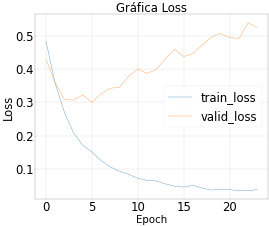

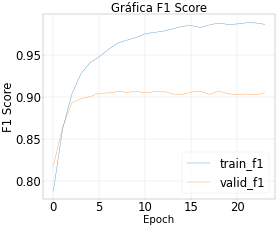

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases originales/rnn_Frases originales/version_5/checkpoints/epoch=23-step=2880.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases originales/rnn_Frases originales/version_5/checkpoints/epoch=23-step=2880.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

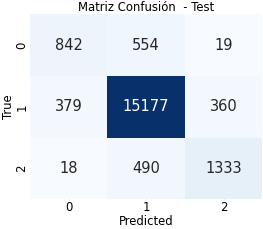

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.60      0.63      1415
           1       0.94      0.95      0.94     15916
           2       0.78      0.72      0.75      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.76      0.78     19172
weighted avg       0.90      0.91      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.905069887638092     │
│          test_f1          │    0.9029936790466309     │
│         test_loss         │     0.52597576379776      │
│      test_precision       │    0.9016627073287964     │
│        test_recall        │     0.905069887638092     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases originales en minúsculas, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales en minúsculas en minutos: 0.94


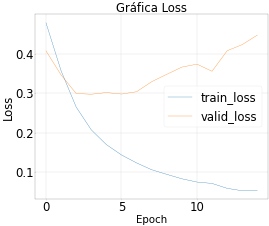

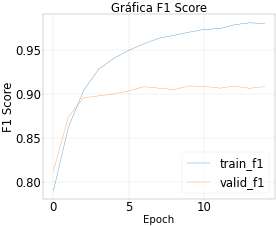

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases originales en minúsculas/rnn_Frases originales en minúsculas/version_4/checkpoints/epoch=14-step=1800.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases originales en minúsculas/rnn_Frases originales en minúsculas/version_4/checkpoints/epoch=14-step=1800.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

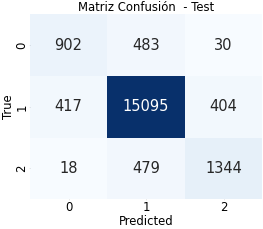

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.64      0.66      1415
           1       0.94      0.95      0.94     15916
           2       0.76      0.73      0.74      1841

    accuracy                           0.90     19172
   macro avg       0.79      0.77      0.78     19172
weighted avg       0.90      0.90      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9044961333274841     │
│          test_f1          │    0.9035778045654297     │
│         test_loss         │    0.47074902057647705    │
│      test_precision       │    0.9028109908103943     │
│        test_recall        │    0.9044961333274841     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases originales con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales con stemming en minutos: 1.24


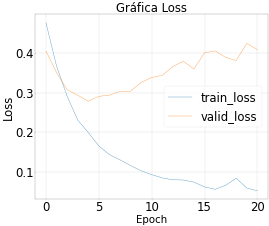

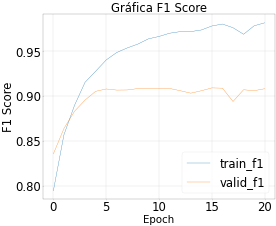

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases originales con stemming/rnn_Frases originales con stemming/version_4/checkpoints/epoch=20-step=2520.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases originales con stemming/rnn_Frases originales con stemming/version_4/checkpoints/epoch=20-step=2520.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

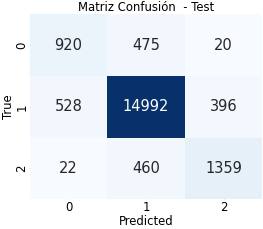

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      1415
           1       0.94      0.94      0.94     15916
           2       0.77      0.74      0.75      1841

    accuracy                           0.90     19172
   macro avg       0.78      0.78      0.78     19172
weighted avg       0.90      0.90      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9008449912071228     │
│          test_f1          │    0.9009538292884827     │
│         test_loss         │    0.4295220673084259     │
│      test_precision       │    0.9011452198028564     │
│        test_recall        │    0.9008449912071228     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases originales con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales con lemmatization en minutos: 0.83


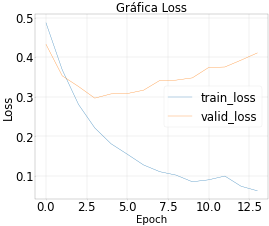

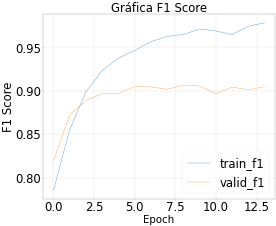

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases originales con lemmatization/rnn_Frases originales con lemmatization/version_4/checkpoints/epoch=13-step=1680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases originales con lemmatization/rnn_Frases originales con lemmatization/version_4/checkpoints/epoch=13-step=1680.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

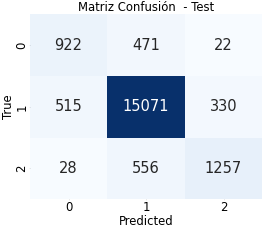

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      1415
           1       0.94      0.95      0.94     15916
           2       0.78      0.68      0.73      1841

    accuracy                           0.90     19172
   macro avg       0.78      0.76      0.77     19172
weighted avg       0.90      0.90      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8997496366500854     │
│          test_f1          │    0.8988547325134277     │
│         test_loss         │     0.42812380194664      │
│      test_precision       │    0.8986745476722717     │
│        test_recall        │    0.8997496366500854     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases sin stop words, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words en minutos: 0.61


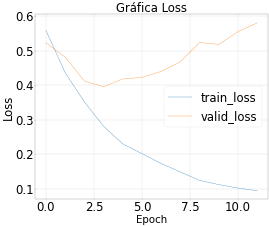

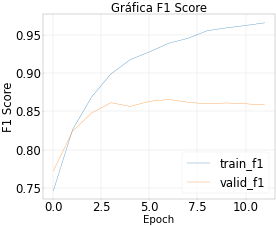

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words/rnn_Frases sin stop words/version_4/checkpoints/epoch=11-step=1068.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words/rnn_Frases sin stop words/version_4/checkpoints/epoch=11-step=1068.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

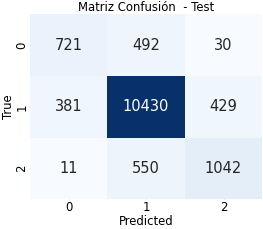

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.58      0.61      1243
           1       0.91      0.93      0.92     11240
           2       0.69      0.65      0.67      1603

    accuracy                           0.87     14086
   macro avg       0.75      0.72      0.73     14086
weighted avg       0.86      0.87      0.86     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8656112551689148     │
│          test_f1          │    0.8633028268814087     │
│         test_loss         │    0.5569087862968445     │
│      test_precision       │    0.8616423606872559     │
│        test_recall        │    0.8656112551689148     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases sin stop words con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words con stemming en minutos: 0.58


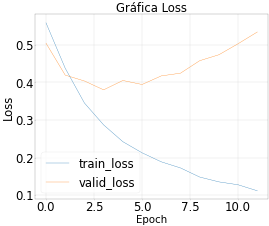

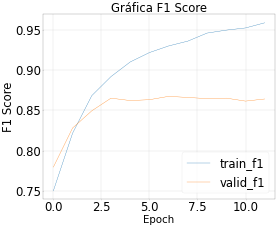

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words con stemming/rnn_Frases sin stop words con stemming/version_4/checkpoints/epoch=11-step=1068.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words con stemming/rnn_Frases sin stop words con stemming/version_4/checkpoints/epoch=11-step=1068.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

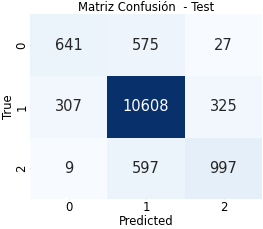

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.52      0.58      1243
           1       0.90      0.94      0.92     11240
           2       0.74      0.62      0.68      1603

    accuracy                           0.87     14086
   macro avg       0.77      0.69      0.73     14086
weighted avg       0.86      0.87      0.86     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8693738579750061     │
│          test_f1          │    0.8637139797210693     │
│         test_loss         │    0.5316070318222046     │
│      test_precision       │    0.8617784976959229     │
│        test_recall        │    0.8693738579750061     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: True, con dataset: Frases sin stop words con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | RNN                 | 197 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words con lemmatization en minutos: 0.82


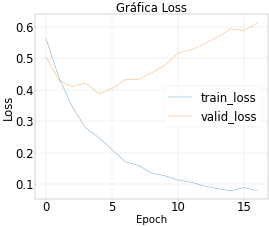

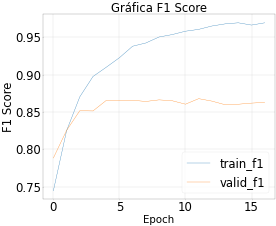

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words con lemmatization/rnn_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=16-step=1513.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_True/Frases sin stop words con lemmatization/rnn_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=16-step=1513.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

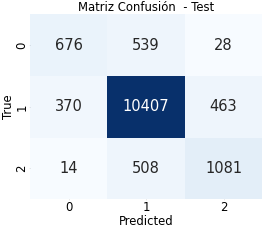

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.54      0.59      1243
           1       0.91      0.93      0.92     11240
           2       0.69      0.67      0.68      1603

    accuracy                           0.86     14086
   macro avg       0.74      0.71      0.73     14086
weighted avg       0.86      0.86      0.86     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.863552451133728     │
│          test_f1          │    0.8611482381820679     │
│         test_loss         │    0.5986547470092773     │
│      test_precision       │    0.8595474362373352     │
│        test_recall        │     0.863552451133728     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases originales, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales en minutos: 0.77


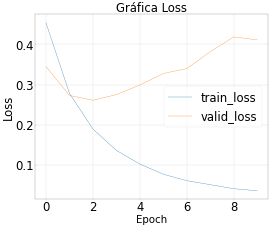

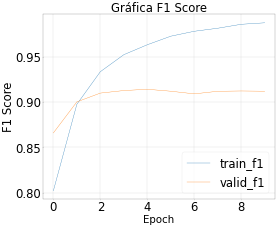

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales/rnn_lstm_Frases originales/version_3/checkpoints/epoch=9-step=1200.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales/rnn_lstm_Frases originales/version_3/checkpoints/epoch=9-step=1200.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

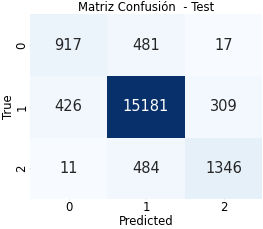

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.66      1415
           1       0.94      0.95      0.95     15916
           2       0.81      0.73      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.78      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.909868597984314     │
│          test_f1          │    0.9086193442344666     │
│         test_loss         │    0.4273582696914673     │
│      test_precision       │    0.9078399538993835     │
│        test_recall        │     0.909868597984314     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases originales en minúsculas, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales en minúsculas en minutos: 0.81


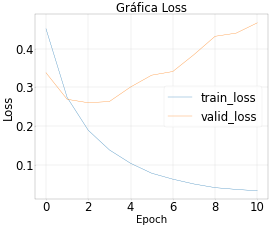

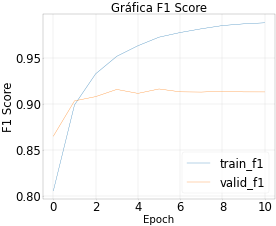

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales en minúsculas/rnn_lstm_Frases originales en minúsculas/version_3/checkpoints/epoch=10-step=1320.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales en minúsculas/rnn_lstm_Frases originales en minúsculas/version_3/checkpoints/epoch=10-step=1320.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

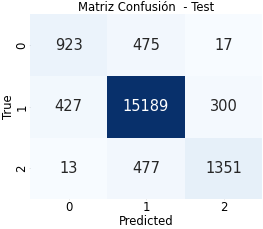

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.66      1415
           1       0.94      0.95      0.95     15916
           2       0.81      0.73      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.78      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9108595848083496     │
│          test_f1          │    0.9096742868423462     │
│         test_loss         │    0.47891557216644287    │
│      test_precision       │     0.908961296081543     │
│        test_recall        │    0.9108595848083496     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases originales con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales con stemming en minutos: 1.12


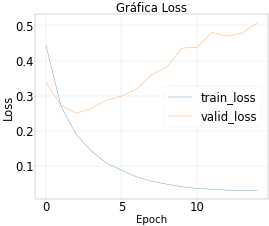

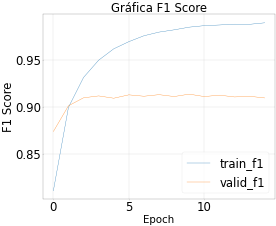

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales con stemming/rnn_lstm_Frases originales con stemming/version_3/checkpoints/epoch=14-step=1800.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales con stemming/rnn_lstm_Frases originales con stemming/version_3/checkpoints/epoch=14-step=1800.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

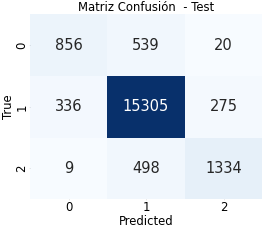

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.60      0.65      1415
           1       0.94      0.96      0.95     15916
           2       0.82      0.72      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.82      0.76      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9125286936759949     │
│          test_f1          │    0.9098897576332092     │
│         test_loss         │     0.499846875667572     │
│      test_precision       │    0.9087297320365906     │
│        test_recall        │    0.9125286936759949     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases originales con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales con lemmatization en minutos: 0.89


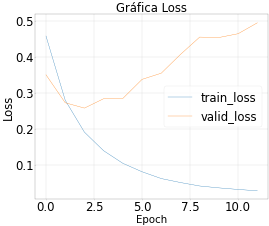

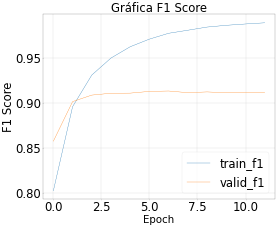

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales con lemmatization/rnn_lstm_Frases originales con lemmatization/version_3/checkpoints/epoch=11-step=1440.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases originales con lemmatization/rnn_lstm_Frases originales con lemmatization/version_3/checkpoints/epoch=11-step=1440.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

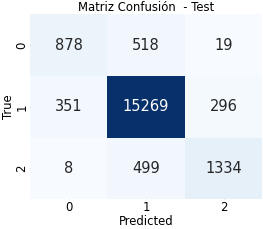

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.62      0.66      1415
           1       0.94      0.96      0.95     15916
           2       0.81      0.72      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.82      0.77      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9117984771728516     │
│          test_f1          │     0.909549355506897     │
│         test_loss         │    0.5022611618041992     │
│      test_precision       │    0.9083960056304932     │
│        test_recall        │    0.9117984771728516     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases sin stop words, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words en minutos: 0.52


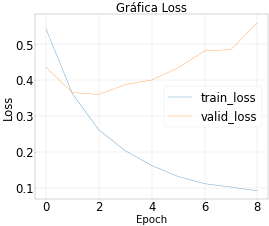

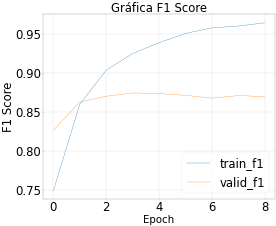

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words/rnn_lstm_Frases sin stop words/version_3/checkpoints/epoch=8-step=801.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words/rnn_lstm_Frases sin stop words/version_3/checkpoints/epoch=8-step=801.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

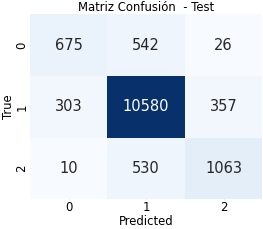

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.54      0.61      1243
           1       0.91      0.94      0.92     11240
           2       0.74      0.66      0.70      1603

    accuracy                           0.87     14086
   macro avg       0.78      0.72      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8744852542877197     │
│          test_f1          │    0.8703303933143616     │
│         test_loss         │    0.5680409073829651     │
│      test_precision       │    0.8684889078140259     │
│        test_recall        │    0.8744852542877197     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases sin stop words con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words con stemming en minutos: 0.61


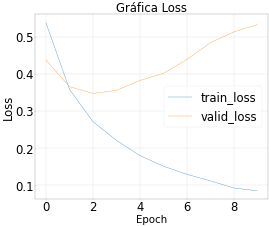

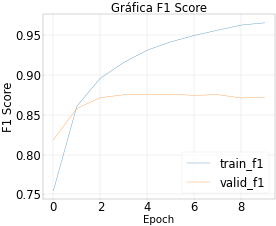

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words con stemming/rnn_lstm_Frases sin stop words con stemming/version_3/checkpoints/epoch=9-step=890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words con stemming/rnn_lstm_Frases sin stop words con stemming/version_3/checkpoints/epoch=9-step=890.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

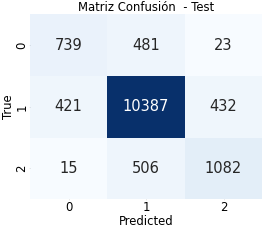

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.59      0.61      1243
           1       0.91      0.92      0.92     11240
           2       0.70      0.67      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.75      0.73      0.74     14086
weighted avg       0.86      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8666761517524719     │
│          test_f1          │    0.8653965592384338     │
│         test_loss         │     0.544677197933197     │
│      test_precision       │    0.8643232583999634     │
│        test_recall        │    0.8666761517524719     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: True, con dataset: Frases sin stop words con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | LSTM                | 790 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words con lemmatization en minutos: 0.59


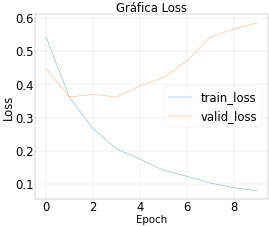

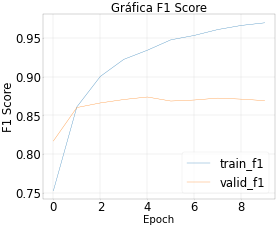

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words con lemmatization/rnn_lstm_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=9-step=890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_True/Frases sin stop words con lemmatization/rnn_lstm_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=9-step=890.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

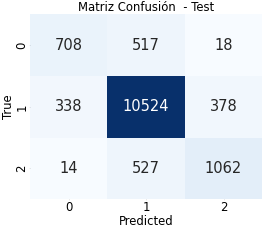

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.57      0.61      1243
           1       0.91      0.94      0.92     11240
           2       0.73      0.66      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.77      0.72      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8727814555168152     │
│          test_f1          │    0.8696025013923645     │
│         test_loss         │    0.5828045010566711     │
│      test_precision       │    0.8677729368209839     │
│        test_recall        │    0.8727814555168152     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases originales, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales en minutos: 0.76


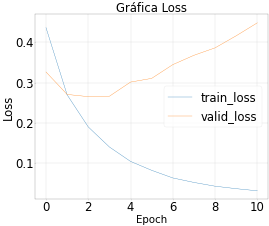

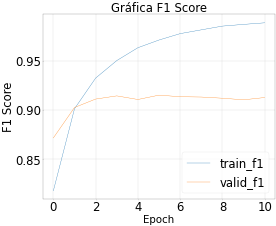

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales/rnn_gru_Frases originales/version_3/checkpoints/epoch=10-step=1320.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales/rnn_gru_Frases originales/version_3/checkpoints/epoch=10-step=1320.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

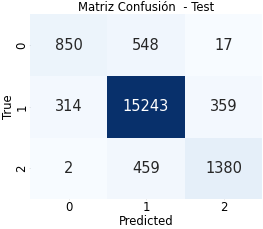

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.60      0.66      1415
           1       0.94      0.96      0.95     15916
           2       0.79      0.75      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.82      0.77      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9113811254501343     │
│          test_f1          │    0.9091036915779114     │
│         test_loss         │    0.4769183397293091     │
│      test_precision       │    0.9079916477203369     │
│        test_recall        │    0.9113811254501343     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases originales en minúsculas, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales en minúsculas en minutos: 0.64


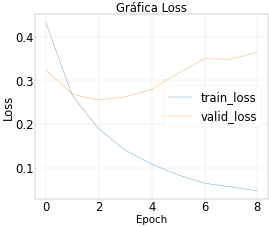

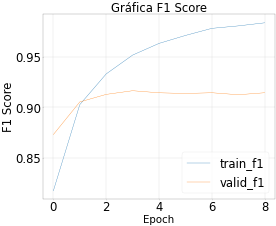

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales en minúsculas/rnn_gru_Frases originales en minúsculas/version_3/checkpoints/epoch=8-step=1080.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales en minúsculas/rnn_gru_Frases originales en minúsculas/version_3/checkpoints/epoch=8-step=1080.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

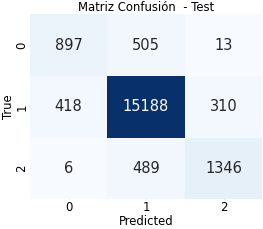

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.63      0.66      1415
           1       0.94      0.95      0.95     15916
           2       0.81      0.73      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.77      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9091904759407043     │
│          test_f1          │    0.9076732397079468     │
│         test_loss         │    0.38226333260536194    │
│      test_precision       │    0.9067327976226807     │
│        test_recall        │    0.9091904759407043     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases originales con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales con stemming en minutos: 0.69


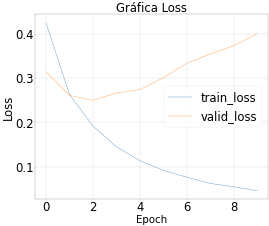

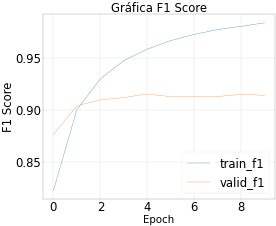

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales con stemming/rnn_gru_Frases originales con stemming/version_3/checkpoints/epoch=9-step=1200.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales con stemming/rnn_gru_Frases originales con stemming/version_3/checkpoints/epoch=9-step=1200.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

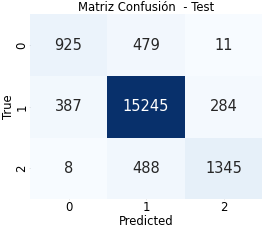

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.65      0.68      1415
           1       0.94      0.96      0.95     15916
           2       0.82      0.73      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.82      0.78      0.80     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9135718941688538     │
│          test_f1          │    0.9119726419448853     │
│         test_loss         │    0.40742045640945435    │
│      test_precision       │    0.9111241102218628     │
│        test_recall        │    0.9135718941688538     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases originales con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales con lemmatization en minutos: 0.84


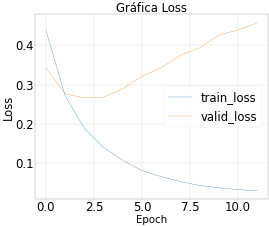

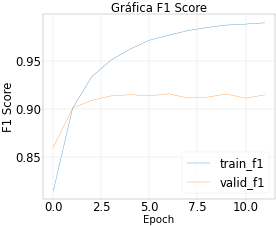

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales con lemmatization/rnn_gru_Frases originales con lemmatization/version_3/checkpoints/epoch=11-step=1440.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases originales con lemmatization/rnn_gru_Frases originales con lemmatization/version_3/checkpoints/epoch=11-step=1440.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

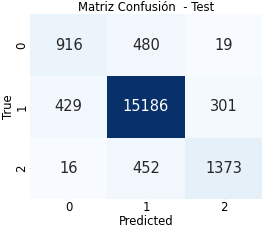

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.65      0.66      1415
           1       0.94      0.95      0.95     15916
           2       0.81      0.75      0.78      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.78      0.80     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.911485493183136     │
│          test_f1          │    0.9104192852973938     │
│         test_loss         │     0.478525310754776     │
│      test_precision       │    0.9097146987915039     │
│        test_recall        │     0.911485493183136     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases sin stop words, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words en minutos: 0.57


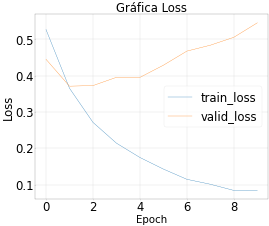

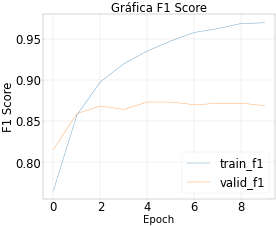

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words/rnn_gru_Frases sin stop words/version_3/checkpoints/epoch=9-step=890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words/rnn_gru_Frases sin stop words/version_3/checkpoints/epoch=9-step=890.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

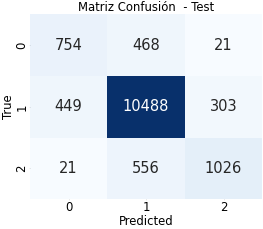

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.61      0.61      1243
           1       0.91      0.93      0.92     11240
           2       0.76      0.64      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.76      0.73      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8709356784820557     │
│          test_f1          │     0.868687093257904     │
│         test_loss         │    0.5422724485397339     │
│      test_precision       │    0.8678247928619385     │
│        test_recall        │    0.8709356784820557     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases sin stop words con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words con stemming en minutos: 0.59


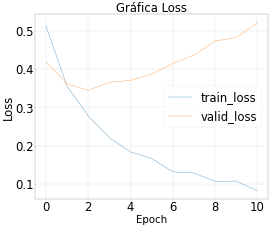

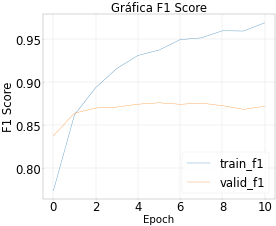

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words con stemming/rnn_gru_Frases sin stop words con stemming/version_3/checkpoints/epoch=10-step=979.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words con stemming/rnn_gru_Frases sin stop words con stemming/version_3/checkpoints/epoch=10-step=979.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

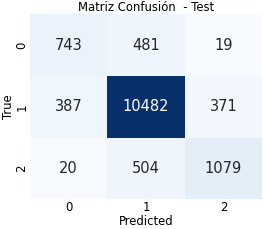

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.60      0.62      1243
           1       0.91      0.93      0.92     11240
           2       0.73      0.67      0.70      1603

    accuracy                           0.87     14086
   macro avg       0.76      0.73      0.75     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8734914064407349     │
│          test_f1          │     0.871443510055542     │
│         test_loss         │    0.5271636247634888     │
│      test_precision       │    0.8700134754180908     │
│        test_recall        │    0.8734914064407349     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: True, con dataset: Frases sin stop words con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | GRU                 | 592 K  | train
2  | classifier      | Linear              | 771    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words con lemmatization en minutos: 0.60


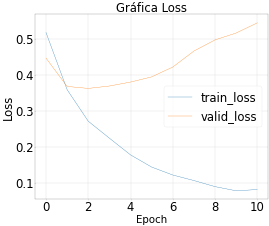

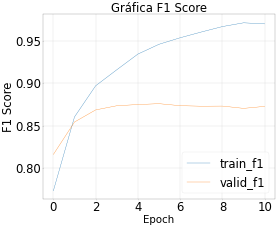

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words con lemmatization/rnn_gru_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=10-step=979.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_True/Frases sin stop words con lemmatization/rnn_gru_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=10-step=979.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

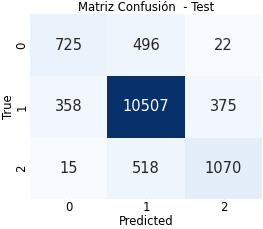

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.58      0.62      1243
           1       0.91      0.93      0.92     11240
           2       0.73      0.67      0.70      1603

    accuracy                           0.87     14086
   macro avg       0.77      0.73      0.75     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8733494281768799     │
│          test_f1          │    0.8706936240196228     │
│         test_loss         │    0.5621480345726013     │
│      test_precision       │    0.8689954876899719     │
│        test_recall        │    0.8733494281768799     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases originales, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales en minutos: 0.85


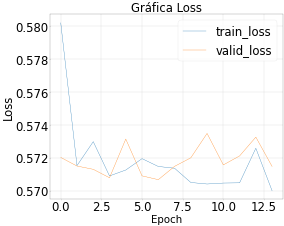

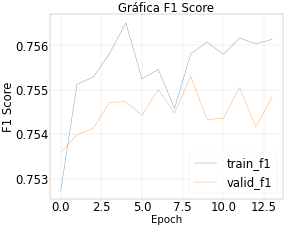

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases originales/rnn_Frases originales/version_3/checkpoints/epoch=13-step=1680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases originales/rnn_Frases originales/version_3/checkpoints/epoch=13-step=1680.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

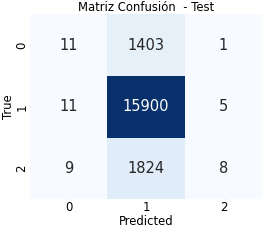

Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.01      0.02      1415
           1       0.83      1.00      0.91     15916
           2       0.57      0.00      0.01      1841

    accuracy                           0.83     19172
   macro avg       0.59      0.34      0.31     19172
weighted avg       0.77      0.83      0.76     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8303254842758179     │
│          test_f1          │    0.7552934885025024     │
│         test_loss         │    0.5718653202056885     │
│      test_precision       │    0.7711682915687561     │
│        test_recall        │    0.8303254842758179     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases originales en minúsculas, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales en minúsculas en minutos: 1.66


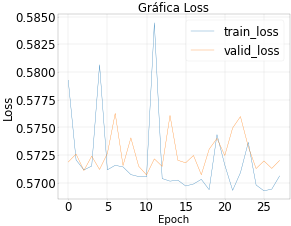

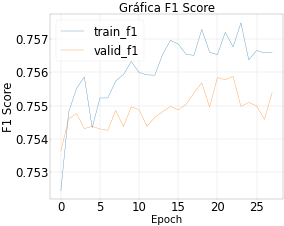

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases originales en minúsculas/rnn_Frases originales en minúsculas/version_3/checkpoints/epoch=27-step=3360.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases originales en minúsculas/rnn_Frases originales en minúsculas/version_3/checkpoints/epoch=27-step=3360.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

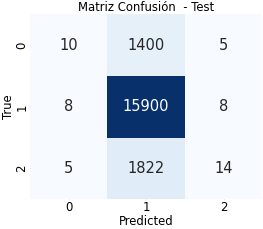

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.01      0.01      1415
           1       0.83      1.00      0.91     15916
           2       0.52      0.01      0.01      1841

    accuracy                           0.83     19172
   macro avg       0.59      0.34      0.31     19172
weighted avg       0.77      0.83      0.76     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8305862545967102     │
│          test_f1          │     0.755915641784668     │
│         test_loss         │    0.5714958906173706     │
│      test_precision       │    0.7721683382987976     │
│        test_recall        │    0.8305862545967102     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases originales con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales con stemming en minutos: 1.41


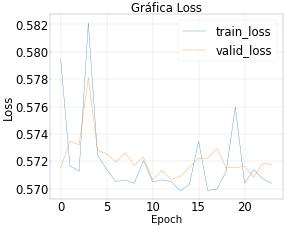

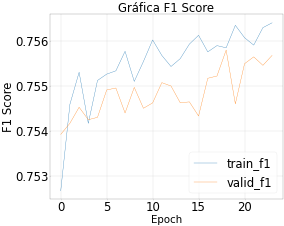

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases originales con stemming/rnn_Frases originales con stemming/version_3/checkpoints/epoch=23-step=2880.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases originales con stemming/rnn_Frases originales con stemming/version_3/checkpoints/epoch=23-step=2880.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

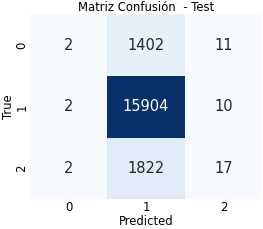

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.00      0.00      1415
           1       0.83      1.00      0.91     15916
           2       0.45      0.01      0.02      1841

    accuracy                           0.83     19172
   macro avg       0.54      0.34      0.31     19172
weighted avg       0.76      0.83      0.76     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8305341005325317     │
│          test_f1          │    0.7554556131362915     │
│         test_loss         │     0.571509599685669     │
│      test_precision       │    0.7578057050704956     │
│        test_recall        │    0.8305341005325317     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases originales con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases originales con lemmatization en minutos: 0.80


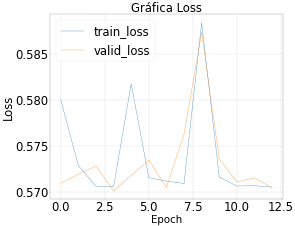

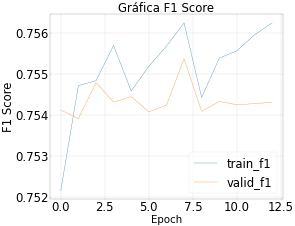

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases originales con lemmatization/rnn_Frases originales con lemmatization/version_3/checkpoints/epoch=12-step=1560.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases originales con lemmatization/rnn_Frases originales con lemmatization/version_3/checkpoints/epoch=12-step=1560.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

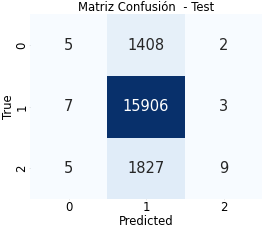

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.00      0.01      1415
           1       0.83      1.00      0.91     15916
           2       0.64      0.00      0.01      1841

    accuracy                           0.83     19172
   macro avg       0.59      0.34      0.31     19172
weighted avg       0.77      0.83      0.75     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8303776383399963     │
│          test_f1          │    0.7547728419303894     │
│         test_loss         │    0.5704160332679749     │
│      test_precision       │    0.7733011841773987     │
│        test_recall        │    0.8303776383399963     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases sin stop words, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words en minutos: 0.60


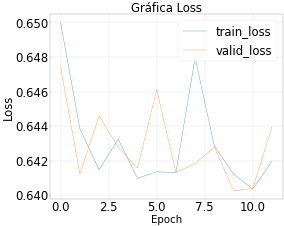

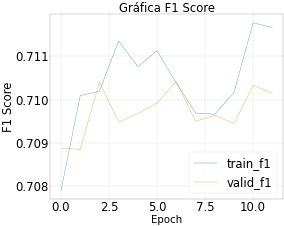

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words/rnn_Frases sin stop words/version_3/checkpoints/epoch=11-step=1068.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words/rnn_Frases sin stop words/version_3/checkpoints/epoch=11-step=1068.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

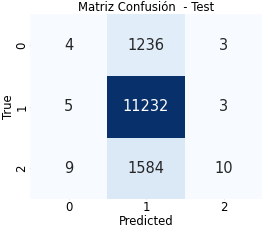

Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.00      0.01      1243
           1       0.80      1.00      0.89     11240
           2       0.62      0.01      0.01      1603

    accuracy                           0.80     14086
   macro avg       0.55      0.34      0.30     14086
weighted avg       0.73      0.80      0.71     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7983813881874084     │
│          test_f1          │    0.7106984257698059     │
│         test_loss         │     0.643031656742096     │
│      test_precision       │    0.7285544872283936     │
│        test_recall        │    0.7983813881874084     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases sin stop words con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words con stemming en minutos: 0.31


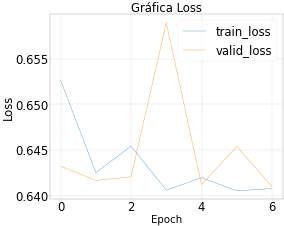

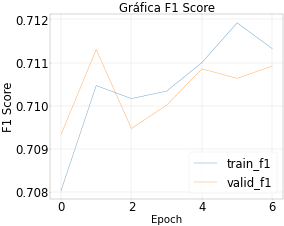

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words con stemming/rnn_Frases sin stop words con stemming/version_3/checkpoints/epoch=6-step=623.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words con stemming/rnn_Frases sin stop words con stemming/version_3/checkpoints/epoch=6-step=623.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

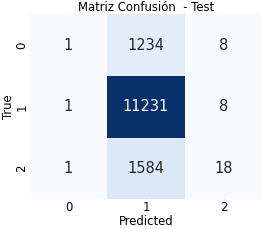

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.00      0.00      1243
           1       0.80      1.00      0.89     11240
           2       0.53      0.01      0.02      1603

    accuracy                           0.80     14086
   macro avg       0.55      0.34      0.30     14086
weighted avg       0.73      0.80      0.71     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7986653447151184     │
│          test_f1          │    0.7113980650901794     │
│         test_loss         │    0.6403973698616028     │
│      test_precision       │    0.7275606393814087     │
│        test_recall        │    0.7986653447151184     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn, bidireccional: False, con dataset: Frases sin stop words con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | RNN                 | 82.4 K | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn con Frases sin stop words con lemmatization en minutos: 0.97


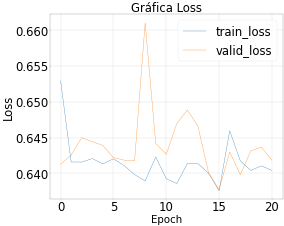

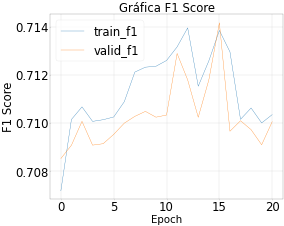

Restoring states from the checkpoint path at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words con lemmatization/rnn_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=20-step=1869.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_Bidirec_False/Frases sin stop words con lemmatization/rnn_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=20-step=1869.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

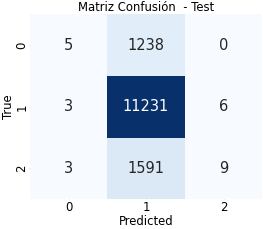

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.00      0.01      1243
           1       0.80      1.00      0.89     11240
           2       0.60      0.01      0.01      1603

    accuracy                           0.80     14086
   macro avg       0.62      0.34      0.30     14086
weighted avg       0.75      0.80      0.71     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.798310399055481     │
│          test_f1          │    0.7104153037071228     │
│         test_loss         │    0.6422117948532104     │
│      test_precision       │    0.7457908391952515     │
│        test_recall        │     0.798310399055481     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases originales, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales en minutos: 0.99


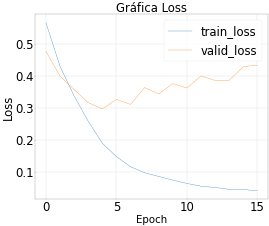

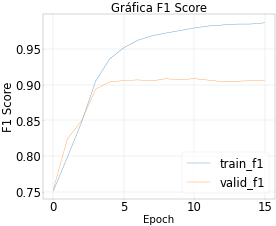

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales/rnn_lstm_Frases originales/version_3/checkpoints/epoch=15-step=1920.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales/rnn_lstm_Frases originales/version_3/checkpoints/epoch=15-step=1920.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

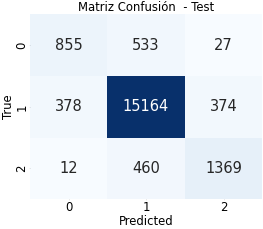

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.60      0.64      1415
           1       0.94      0.95      0.95     15916
           2       0.77      0.74      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.77      0.78     19172
weighted avg       0.90      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9069476127624512     │
│          test_f1          │    0.9052585959434509     │
│         test_loss         │    0.43723201751708984    │
│      test_precision       │    0.9041035175323486     │
│        test_recall        │    0.9069476127624512     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases originales en minúsculas, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales en minúsculas en minutos: 0.87


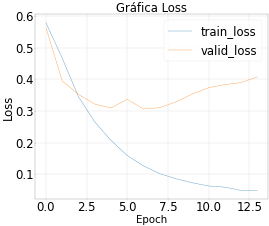

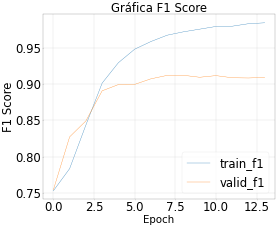

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales en minúsculas/rnn_lstm_Frases originales en minúsculas/version_3/checkpoints/epoch=13-step=1680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales en minúsculas/rnn_lstm_Frases originales en minúsculas/version_3/checkpoints/epoch=13-step=1680.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

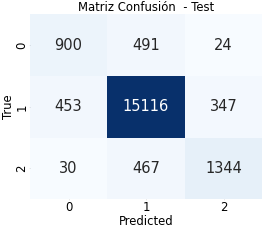

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.64      0.64      1415
           1       0.94      0.95      0.95     15916
           2       0.78      0.73      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.79      0.77      0.78     19172
weighted avg       0.90      0.91      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9054871797561646     │
│          test_f1          │    0.9046138525009155     │
│         test_loss         │    0.4169367253780365     │
│      test_precision       │    0.9039737582206726     │
│        test_recall        │    0.9054871797561646     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases originales con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales con stemming en minutos: 1.14


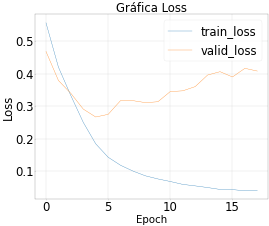

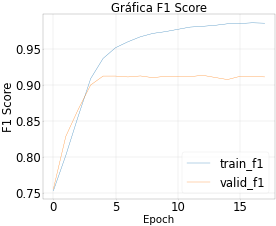

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales con stemming/rnn_lstm_Frases originales con stemming/version_3/checkpoints/epoch=17-step=2160.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales con stemming/rnn_lstm_Frases originales con stemming/version_3/checkpoints/epoch=17-step=2160.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

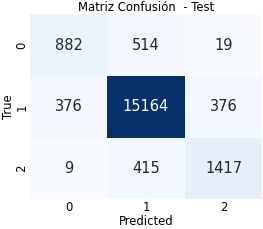

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.62      0.66      1415
           1       0.94      0.95      0.95     15916
           2       0.78      0.77      0.78      1841

    accuracy                           0.91     19172
   macro avg       0.81      0.78      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9108595848083496     │
│          test_f1          │    0.9096113443374634     │
│         test_loss         │    0.4101378917694092     │
│      test_precision       │    0.9087170362472534     │
│        test_recall        │    0.9108595848083496     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases originales con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases originales con lemmatization en minutos: 0.82


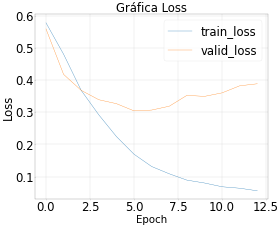

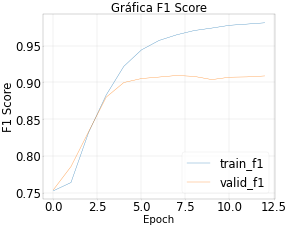

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales con lemmatization/rnn_lstm_Frases originales con lemmatization/version_3/checkpoints/epoch=12-step=1560.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases originales con lemmatization/rnn_lstm_Frases originales con lemmatization/version_3/checkpoints/epoch=12-step=1560.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

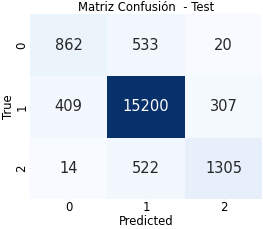

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.61      0.64      1415
           1       0.94      0.96      0.94     15916
           2       0.80      0.71      0.75      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.76      0.78     19172
weighted avg       0.90      0.91      0.90     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9058522582054138     │
│          test_f1          │    0.9037590026855469     │
│         test_loss         │    0.41233623027801514    │
│      test_precision       │    0.9025835990905762     │
│        test_recall        │    0.9058522582054138     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases sin stop words, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words en minutos: 0.64


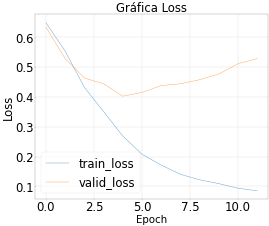

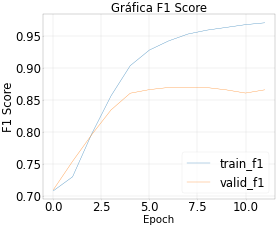

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words/rnn_lstm_Frases sin stop words/version_3/checkpoints/epoch=11-step=1068.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words/rnn_lstm_Frases sin stop words/version_3/checkpoints/epoch=11-step=1068.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

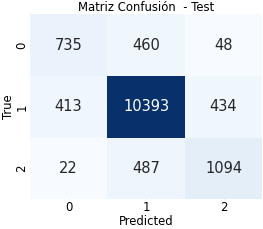

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.59      0.61      1243
           1       0.92      0.92      0.92     11240
           2       0.69      0.68      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.75      0.73      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8676700592041016     │
│          test_f1          │    0.8666406869888306     │
│         test_loss         │    0.5377475619316101     │
│      test_precision       │    0.8657498359680176     │
│        test_recall        │    0.8676700592041016     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases sin stop words con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words con stemming en minutos: 0.61


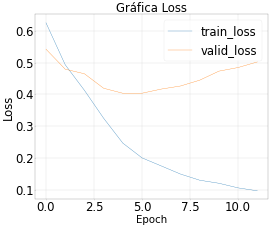

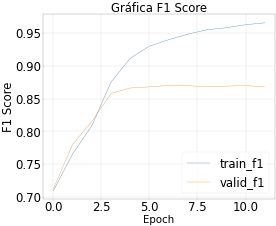

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words con stemming/rnn_lstm_Frases sin stop words con stemming/version_3/checkpoints/epoch=11-step=1068.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words con stemming/rnn_lstm_Frases sin stop words con stemming/version_3/checkpoints/epoch=11-step=1068.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

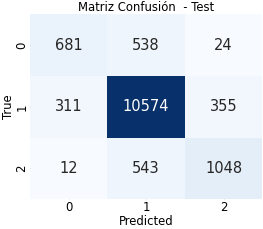

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.55      0.61      1243
           1       0.91      0.94      0.92     11240
           2       0.73      0.65      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.77      0.71      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8734204173088074     │
│          test_f1          │    0.8692773580551147     │
│         test_loss         │    0.49936559796333313    │
│      test_precision       │    0.8673759698867798     │
│        test_recall        │    0.8734204173088074     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_lstm, bidireccional: False, con dataset: Frases sin stop words con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | LSTM                | 329 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_lstm con Frases sin stop words con lemmatization en minutos: 0.72


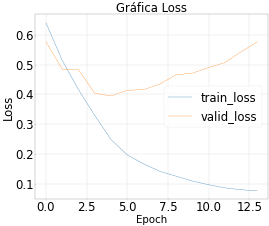

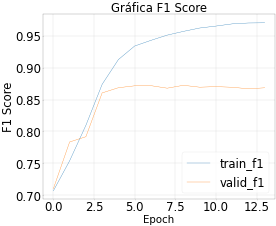

Restoring states from the checkpoint path at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words con lemmatization/rnn_lstm_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=13-step=1246.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_LSTM_Bidirec_False/Frases sin stop words con lemmatization/rnn_lstm_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=13-step=1246.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

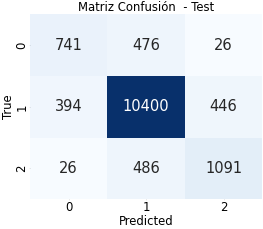

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.60      0.62      1243
           1       0.92      0.93      0.92     11240
           2       0.70      0.68      0.69      1603

    accuracy                           0.87     14086
   macro avg       0.75      0.73      0.74     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8683799505233765     │
│          test_f1          │     0.867167592048645     │
│         test_loss         │    0.5876079201698303     │
│      test_precision       │    0.8661497831344604     │
│        test_recall        │    0.8683799505233765     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases originales, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.6 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales en minutos: 0.88


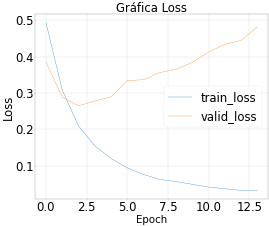

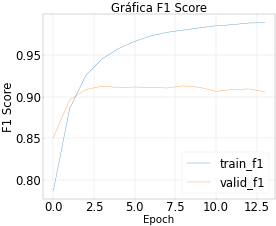

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales/rnn_gru_Frases originales/version_3/checkpoints/epoch=13-step=1680.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales/rnn_gru_Frases originales/version_3/checkpoints/epoch=13-step=1680.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

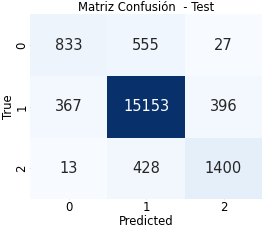

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.59      0.63      1415
           1       0.94      0.95      0.95     15916
           2       0.77      0.76      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.77      0.78     19172
weighted avg       0.90      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9068433046340942     │
│          test_f1          │    0.9051167368888855     │
│         test_loss         │    0.4941718876361847     │
│      test_precision       │    0.9040238261222839     │
│        test_recall        │    0.9068433046340942     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases originales en minúsculas, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales en minúsculas en minutos: 0.69


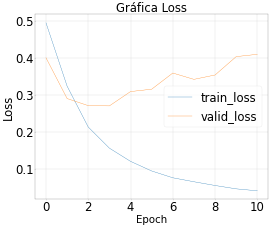

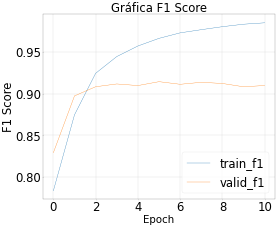

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales en minúsculas/rnn_gru_Frases originales en minúsculas/version_3/checkpoints/epoch=10-step=1320.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales en minúsculas/rnn_gru_Frases originales en minúsculas/version_3/checkpoints/epoch=10-step=1320.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

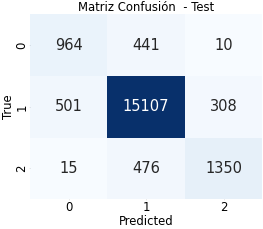

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      1415
           1       0.94      0.95      0.95     15916
           2       0.81      0.73      0.77      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.79      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9086688756942749     │
│          test_f1          │    0.9083471298217773     │
│         test_loss         │    0.42607563734054565    │
│      test_precision       │    0.9084529876708984     │
│        test_recall        │    0.9086688756942749     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases originales con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales con stemming en minutos: 0.73


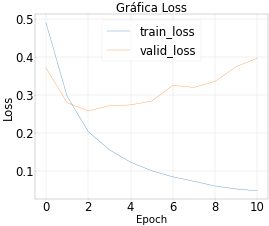

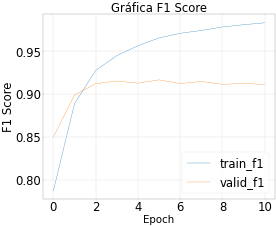

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales con stemming/rnn_gru_Frases originales con stemming/version_3/checkpoints/epoch=10-step=1320.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales con stemming/rnn_gru_Frases originales con stemming/version_3/checkpoints/epoch=10-step=1320.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

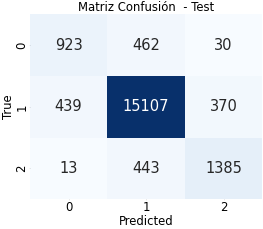

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.65      0.66      1415
           1       0.94      0.95      0.95     15916
           2       0.78      0.75      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.80      0.78      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9083559513092041     │
│          test_f1          │    0.9077926278114319     │
│         test_loss         │    0.4174655079841614     │
│      test_precision       │    0.9072985649108887     │
│        test_recall        │    0.9083559513092041     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases originales con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.3 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases originales con lemmatization en minutos: 0.76


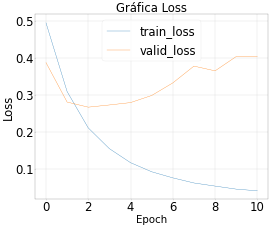

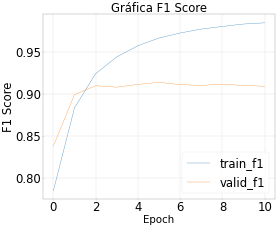

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales con lemmatization/rnn_gru_Frases originales con lemmatization/version_3/checkpoints/epoch=10-step=1320.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases originales con lemmatization/rnn_gru_Frases originales con lemmatization/version_3/checkpoints/epoch=10-step=1320.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

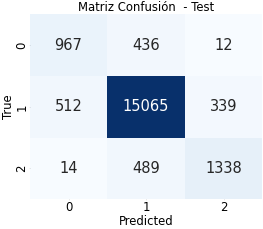

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.68      0.67      1415
           1       0.94      0.95      0.94     15916
           2       0.79      0.73      0.76      1841

    accuracy                           0.91     19172
   macro avg       0.79      0.79      0.79     19172
weighted avg       0.91      0.91      0.91     19172



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9060087203979492     │
│          test_f1          │    0.9058384895324707     │
│         test_loss         │    0.4223724901676178     │
│      test_precision       │    0.9060177803039551     │
│        test_recall        │    0.9060087203979492     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases sin stop words, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 4.2 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words en minutos: 0.49


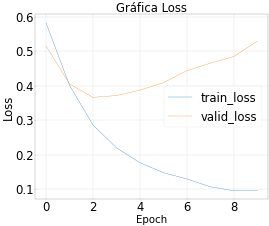

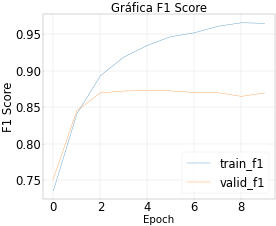

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words/rnn_gru_Frases sin stop words/version_3/checkpoints/epoch=9-step=890.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words/rnn_gru_Frases sin stop words/version_3/checkpoints/epoch=9-step=890.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

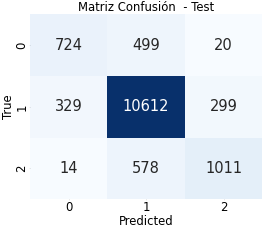

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.58      0.63      1243
           1       0.91      0.94      0.93     11240
           2       0.76      0.63      0.69      1603

    accuracy                           0.88     14086
   macro avg       0.78      0.72      0.75     14086
weighted avg       0.87      0.88      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8765440583229065     │
│          test_f1          │    0.8723881244659424     │
│         test_loss         │    0.5319189429283142     │
│      test_precision       │    0.8708159923553467     │
│        test_recall        │    0.8765440583229065     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases sin stop words con stemming, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.1 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words con stemming en minutos: 0.74


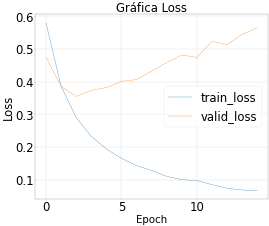

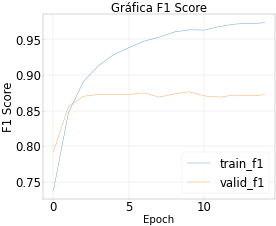

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words con stemming/rnn_gru_Frases sin stop words con stemming/version_3/checkpoints/epoch=14-step=1335.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words con stemming/rnn_gru_Frases sin stop words con stemming/version_3/checkpoints/epoch=14-step=1335.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

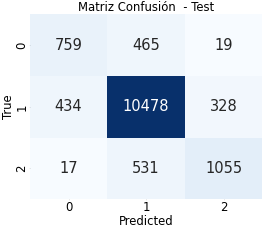

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.61      0.62      1243
           1       0.91      0.93      0.92     11240
           2       0.75      0.66      0.70      1603

    accuracy                           0.87     14086
   macro avg       0.76      0.73      0.75     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.872639536857605     │
│          test_f1          │    0.8707108497619629     │
│         test_loss         │    0.5665720701217651     │
│      test_precision       │    0.8696765899658203     │
│        test_recall        │     0.872639536857605     │
└───────────────────────────┴───────────────────────────┘


Entrenando modelo: rnn_gru, bidireccional: False, con dataset: Frases sin stop words con lemmatization, con patience: 5...



Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | embedding       | Embedding           | 3.8 M  | train
1  | model           | GRU                 | 247 K  | train
2  | classifier      | Linear              | 387    | train
3  | criterion       | CrossEntropyLoss    | 0      | train
4  | train_acc       | MulticlassAccuracy  | 0      | train
5  | valid_acc       | MulticlassAccuracy  | 0      | train
6  | test_acc        | MulticlassAccuracy  | 0      | train
7  | train_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Tiempo de entrenamiento para rnn_gru con Frases sin stop words con lemmatization en minutos: 0.45


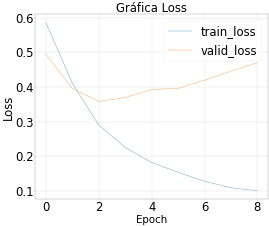

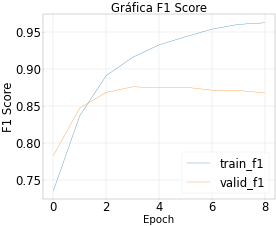

Restoring states from the checkpoint path at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words con lemmatization/rnn_gru_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=8-step=801.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/froh/logs/RNN_GRU_Bidirec_False/Frases sin stop words con lemmatization/rnn_gru_Frases sin stop words con lemmatization/version_3/checkpoints/epoch=8-step=801.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

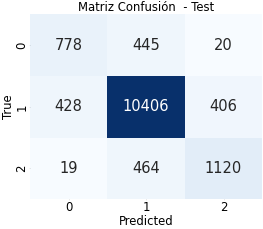

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.63      0.63      1243
           1       0.92      0.93      0.92     11240
           2       0.72      0.70      0.71      1603

    accuracy                           0.87     14086
   macro avg       0.76      0.75      0.75     14086
weighted avg       0.87      0.87      0.87     14086



┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8734914064407349     │
│          test_f1          │    0.8728769421577454     │
│         test_loss         │    0.4745795428752899     │
│      test_precision       │     0.872337818145752     │
│        test_recall        │    0.8734914064407349     │
└───────────────────────────┴───────────────────────────┘

In [9]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks.progress import RichProgressBar
from pytorch_lightning.loggers import CSVLogger
from tqdm import tqdm
from pytorch_lightning.callbacks import TQDMProgressBar
torch.autograd.set_detect_anomaly(True)

# Definición de los parámetros
BATCH_SIZE = 512
NUM_EPOCHS = 50
WARMUP_PARTICION = 6
NUM_WORKERS = 8

# Lista de modelos y datasets
model_types = ['rnn', 'rnn_lstm', 'rnn_gru']
columns_to_process = {
    'Frases originales': ('df', 'Phrase'),
    'Frases originales en minúsculas': ('df', 'lower_text'),
    'Frases originales con stemming': ('df', 'Phrase_Stemmed'),
    'Frases originales con lemmatization': ('df', 'Phrase_Lemmatized'),
    'Frases sin stop words': ('No_Stopwords', 'Phrase_No_Stopwords'),
    'Frases sin stop words con stemming': ('No_Stopwords', 'Phrase_Stemmed'),
    'Frases sin stop words con lemmatization': ('No_Stopwords', 'Phrase_Lemmatized')
}


for PATIENCE in [10, 5]:
    for BIDIREC in [True, False]:
        for model_type in model_types:
            for tipo_data, (dataframe, column) in columns_to_process.items():
                print(f"\nEntrenando modelo: {model_type}, bidireccional: {BIDIREC}, con dataset: {tipo_data}, con patience: {PATIENCE}...\n")
                # Inicialización del DataModule
                data_module = TextDataModule(dataframe=eval(dataframe), column=column, batch_size=BATCH_SIZE)

                # Calcular los pasos totales de entrenamiento y los pasos de calentamiento
                total_training_steps = len(eval(dataframe)) // BATCH_SIZE * NUM_EPOCHS
                warmup_steps = total_training_steps // WARMUP_PARTICION

                # Inicializar el modelo
                model = TextClassifierRNN(
                    model_type=model_type,
                    n_classes=3,
                    hidden_dim=128,
                    n_layers=2,
                    bidirectional=BIDIREC,
                    dropout=0.3,
                    embedding_dim=data_module.embedding_dim,
                    vocab_size=data_module.vocab_size
                )

                # Callbacks para el entrenamiento
                callback_early = EarlyStopping(monitor="valid_f1", mode="max", patience=PATIENCE)

                # Logger para registrar los resultados del entrenamiento
                logger = CSVLogger(save_dir=f"/home/froh/logs/{model_type.upper()}_Bidirec_{BIDIREC}/{tipo_data}", name=f"{model_type}_{tipo_data}")

                # Inicializar el Trainer de PyTorch Lightning
                trainer = pl.Trainer(
                    max_epochs=NUM_EPOCHS,
                    callbacks=[callback_early, TQDMProgressBar(refresh_rate=10, leave=False)],  # Usar la barra de progreso
                    accelerator="auto",
                    devices="auto",
                    logger=logger
                )
                # Entrenamiento del modelo
                start_time = time.time()
                trainer.fit(model, data_module)
                runtime = (time.time() - start_time) / 60
                print(f"Tiempo de entrenamiento para {model_type} con {tipo_data} en minutos: {runtime:.2f}")

                # Curvas de aprendizaje del modelo
                metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

                aggreg_metrics = []
                agg_col = "epoch"
                for i, dfg in metrics.groupby(agg_col):
                    agg = dict(dfg.mean())
                    agg[agg_col] = i
                    aggreg_metrics.append(agg)

                df_metrics = pd.DataFrame(aggreg_metrics)

                # Guardar las curvas de aprendizaje para cada métrica
                metrics_to_plot = {
                    ("train_loss", "valid_loss"): "Loss",
                    ("train_f1", "valid_f1"): "F1 Score"
                }

                for (train_metric, val_metric), ylabel in metrics_to_plot.items():
                    if train_metric in df_metrics.columns and val_metric in df_metrics.columns:
                        fig, ax = plt.subplots(figsize=(ANCHO, ALTO), dpi=DPI)  # Crear una figura con tamaño y DPI
                        # Graficar los datos
                        df_metrics[[train_metric, val_metric]].plot(ax=ax, grid=True, legend=True, xlabel="Epoch", ylabel=ylabel)
                        # Ajustar el tamaño de las etiquetas de los ejes
                        ax.set_xlabel('Epoch', fontsize=WORD*0.7)    # Tamaño de la etiqueta del eje x
                        ax.set_ylabel(ylabel, fontsize=WORD*0.8)     # Tamaño de la etiqueta del eje y
                        # Ajustar el tamaño de las etiquetas de los valores de los ejes
                        ax.tick_params(axis='both', which='major', labelsize=WORD*0.8)  # Tamaño de los valores de los ejes
                        # Ajustar el tamaño del título
                        ax.set_title('Gráfica '+ylabel, fontsize=WORD*0.8)  # Título del gráfico
                        # Ajustar el tamaño de la leyenda
                        ax.legend(fontsize=WORD*0.8)  # Tamaño de la leyenda
                        # Mostrar el gráfico
                        plt.show()


                # Evaluar el conjunto de test
                test_results = trainer.test(model=model, datamodule=data_module, ckpt_path='best')

                # Extraer reportes de la evaluación en el conjunto de test
                cm = model.test_cm  # Matriz de confusión
                cr = model.test_classification_report  # Reporte de clasificación

                # Agregar resultados al DataFrame de resultados
                resultado = {
                    'Data': model_type.upper() + ' Bidireccional: '+ str(BIDIREC) +' . Patience= ' + str(PATIENCE) +' - '+ tipo_data,
                    'Accuracy': test_results[0]['test_acc'],
                    'Precision': test_results[0]['test_precision'],
                    'Recall': test_results[0]['test_recall'],
                    'F1-Score': test_results[0]['test_f1'],
                    'Classification Report': cr,
                    'Matriz de Confusión': cm,
                    'Train Registros': len(data_module.train_dataset),
                    'Test Registros': len(data_module.test_dataset)
                }
                resultados.append(resultado)

## Resultados consolidados

Los resultados de **test** de las métricas Accuracy, Precision, Recall y F1-Score obtenenidos de los modelos Naive Bayes, RNN, GRU y LSTM  con las difentes combinaciones de proprocesamiento posibles de la información, junto con el número de registros para el procesamiento son los siguientes (el número de registros se redece por la eliminación de stopwords que dejan registros vación y la eliminación de duplicados luego de este proceso):

In [10]:
# Configurar pandas para mostrar el texto completo de las columnas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Crear un DataFrame a partir de los resultados
resultados_df = pd.DataFrame(resultados)

resultados_df[['Data', 'Train Registros', 'Test Registros', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]

Data  \
0                                             Naive Bayes - Frases originales - BoW Binario   
1                                          Naive Bayes - Frases originales - BoW Frecuencia   
2                                              Naive Bayes - Frases originales - Bow TF_IDF   
3                               Naive Bayes - Frases originales en minúsculas - BoW Binario   
4                            Naive Bayes - Frases originales en minúsculas - BoW Frecuencia   
5                                Naive Bayes - Frases originales en minúsculas - Bow TF_IDF   
6                                Naive Bayes - Frases originales con stemming - BoW Binario   
7                             Naive Bayes - Frases originales con stemming - BoW Frecuencia   
8                                 Naive Bayes - Frases originales con stemming - Bow TF_IDF   
9                           Naive Bayes - Frases originales con lemmatization - BoW Binario   
10                       Naive Bayes - Frases originales con lemmatization - BoW Frecuencia   
11                           Naive Bayes - Frases originales con lemmatization - Bow TF_IDF   
12                                        Naive Bayes - Frases sin stop words - BoW Binario   
13                                     Naive Bayes - Frases sin stop words - BoW Frecuencia   
14                                         Naive Bayes - Frases sin stop words - Bow TF_IDF   
15                           Naive Bayes - Frases sin stop words con stemming - BoW Binario   
16                        Naive Bayes - Frases sin stop words con stemming - BoW Frecuencia   
17                            Naive Bayes - Frases sin stop words con stemming - Bow TF_IDF   
18                      Naive Bayes - Frases sin stop words con lemmatization - BoW Binario   
19                   Naive Bayes - Frases sin stop words con lemmatization - BoW Frecuencia   
20                       Naive Bayes - Frases sin stop words con lemmatization - Bow TF_IDF   
21                               RNN Bidireccional: True . Patience= 10 - Frases originales   
22                 RNN Bidireccional: True . Patience= 10 - Frases originales en minúsculas   
23                  RNN Bidireccional: True . Patience= 10 - Frases originales con stemming   
24             RNN Bidireccional: True . Patience= 10 - Frases originales con lemmatization   
25                           RNN Bidireccional: True . Patience= 10 - Frases sin stop words   
26              RNN Bidireccional: True . Patience= 10 - Frases sin stop words con stemming   
27         RNN Bidireccional: True . Patience= 10 - Frases sin stop words con lemmatization   
28                          RNN_LSTM Bidireccional: True . Patience= 10 - Frases originales   
29            RNN_LSTM Bidireccional: True . Patience= 10 - Frases originales en minúsculas   
30             RNN_LSTM Bidireccional: True . Patience= 10 - Frases originales con stemming   
31        RNN_LSTM Bidireccional: True . Patience= 10 - Frases originales con lemmatization   
32                      RNN_LSTM Bidireccional: True . Patience= 10 - Frases sin stop words   
33         RNN_LSTM Bidireccional: True . Patience= 10 - Frases sin stop words con stemming   
34    RNN_LSTM Bidireccional: True . Patience= 10 - Frases sin stop words con lemmatization   
35                           RNN_GRU Bidireccional: True . Patience= 10 - Frases originales   
36             RNN_GRU Bidireccional: True . Patience= 10 - Frases originales en minúsculas   
37              RNN_GRU Bidireccional: True . Patience= 10 - Frases originales con stemming   
38         RNN_GRU Bidireccional: True . Patience= 10 - Frases originales con lemmatization   
39                       RNN_GRU Bidireccional: True . Patience= 10 - Frases sin stop words   
40          RNN_GRU Bidireccional: True . Patience= 10 - Frases sin stop words con stemming   
41     RNN_GRU Bidireccional: True . Patience= 10 - Frases sin stop words con lemmatization   
42

Que ordenados de mayor a menor por la métrica weighted F1-Score se rankean de la siguiente manera:

In [11]:
# Configurar pandas para mostrar el texto completo de las columnas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Ordenar por 'F1-Score' de manera descendente
resultados_df_sorted = resultados_df.sort_values(by='F1-Score', ascending=False)
resultados_df_sorted[['Data', 'Train Registros', 'Test Registros', 'Accuracy', 'Precision', 'Recall', 'F1-Score']]

Data  \
79               RNN_GRU Bidireccional: True . Patience= 5 - Frases originales con stemming   
30             RNN_LSTM Bidireccional: True . Patience= 10 - Frases originales con stemming   
80          RNN_GRU Bidireccional: True . Patience= 5 - Frases originales con lemmatization   
72              RNN_LSTM Bidireccional: True . Patience= 5 - Frases originales con stemming   
71             RNN_LSTM Bidireccional: True . Patience= 5 - Frases originales en minúsculas   
37              RNN_GRU Bidireccional: True . Patience= 10 - Frases originales con stemming   
93             RNN_LSTM Bidireccional: False . Patience= 5 - Frases originales con stemming   
73         RNN_LSTM Bidireccional: True . Patience= 5 - Frases originales con lemmatization   
77                            RNN_GRU Bidireccional: True . Patience= 5 - Frases originales   
36             RNN_GRU Bidireccional: True . Patience= 10 - Frases originales en minúsculas   
51            RNN_LSTM Bidireccional: False . Patience= 10 - Frases originales con stemming   
70                           RNN_LSTM Bidireccional: True . Patience= 5 - Frases originales   
38         RNN_GRU Bidireccional: True . Patience= 10 - Frases originales con lemmatization   
99             RNN_GRU Bidireccional: False . Patience= 5 - Frases originales en minúsculas   
29            RNN_LSTM Bidireccional: True . Patience= 10 - Frases originales en minúsculas   
100             RNN_GRU Bidireccional: False . Patience= 5 - Frases originales con stemming   
78              RNN_GRU Bidireccional: True . Patience= 5 - Frases originales en minúsculas   
35                           RNN_GRU Bidireccional: True . Patience= 10 - Frases originales   
28                          RNN_LSTM Bidireccional: True . Patience= 10 - Frases originales   
57            RNN_GRU Bidireccional: False . Patience= 10 - Frases originales en minúsculas   
59        RNN_GRU Bidireccional: False . Patience= 10 - Frases originales con lemmatization   
58             RNN_GRU Bidireccional: False . Patience= 10 - Frases originales con stemming   
31        RNN_LSTM Bidireccional: True . Patience= 10 - Frases originales con lemmatization   
52       RNN_LSTM Bidireccional: False . Patience= 10 - Frases originales con lemmatization   
101        RNN_GRU Bidireccional: False . Patience= 5 - Frases originales con lemmatization   
91                          RNN_LSTM Bidireccional: False . Patience= 5 - Frases originales   
98                           RNN_GRU Bidireccional: False . Patience= 5 - Frases originales   
92            RNN_LSTM Bidireccional: False . Patience= 5 - Frases originales en minúsculas   
56                          RNN_GRU Bidireccional: False . Patience= 10 - Frases originales   
22                 RNN Bidireccional: True . Patience= 10 - Frases originales en minúsculas   
94        RNN_LSTM Bidireccional: False . Patience= 5 - Frases originales con lemmatization   
64                  RNN Bidireccional: True . Patience= 5 - Frases originales en minúsculas   
49                         RNN_LSTM Bidireccional: False . Patience= 10 - Frases originales   
63                                RNN Bidireccional: True . Patience= 5 - Frases originales   
23                  RNN Bidireccional: True . Patience= 10 - Frases originales con stemming   
65                   RNN Bidireccional: True . Patience= 5 - Frases originales con stemming   
24             RNN Bidireccional: True . Patience= 10 - Frases originales con lemmatization   
50           RNN_LSTM Bidireccional: False . Patience= 10 - Frases originales en minúsculas   
66              RNN Bidireccional: True . Patience= 5 - Frases originales con lemmatization   
21                               RNN Bidireccional: True . Patience= 10 - Frases originales   
4                            Naive Bayes - Frases originales en minúsculas - BoW Frecuencia   
1                                          Naive Bayes - Frases originales - BoW Frecuencia   
10

Para este dataset, con características particulares, se observa que las redes GRU y LSTM de preferencia bidireccionales obtienen los mejores resultando con los datasets originales con stemming y lemmatization, seguidas de las RNN en dataset específicos; quedando Naive Bayes y ciertas instancias de RNN en la parte final del ranking. Se alcanzó un 0.911973 en test respecto al weighted F1 Score, bajo las condiciones establecidas en este ejercicio. Por indicios de sobreajuste al usar paciencia de 10 épocas en el entrenamiento se probó también con paciencia de 5 épocas, que para ciertas instancias fue oportuno.